In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from tpot.export_utils import set_param_recursive
import xarray as xr
from SALib.sample import saltelli
from SALib.analyze import sobol
import joblib
import re
import os
import dask
import dask.bag as db

/nfs/b0122/Users/earlacoa/miniconda3/envs/python3/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'axes.grid': False,
    'savefig.dpi': 700,
    'font.size': 12,
    'text.usetex': True,
    'figure.figsize': [5, 5],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)
import geoplot.crs as gcrs
import geoplot

In [3]:
import sys
sys.path.append('/nfs/see-fs-02_users/earlacoa/wrf-analysis/misc/')
from cutshapefile import transform_from_latlon, rasterize
from import_npz import import_npz
import geopandas as gpd
import joblib

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(
    dashboard_address=':5757',
)
client = Client(cluster)

In [ ]:
client

In [ ]:
client.close()
cluster.close()

#### regions

In [ ]:
# regions
gdf_china_north = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_north.shp')
gdf_china_north_east = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_north_east.shp')
gdf_china_east = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_east.shp')
gdf_china_south_central = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_south_central.shp')
gdf_china_south_west = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_south_west.shp')
gdf_china_north_west = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_north_west.shp')

gdf_gba = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/gba.shp')

In [ ]:
gdf_regions = pd.concat([
    gdf_china_north,
    gdf_china_north_east,
    gdf_china_east,
    gdf_china_south_central,
    gdf_china_south_west,
    gdf_china_north_west
]).pipe(gpd.GeoDataFrame)
gdf_regions['regions'] = ['North China', 'North East China', 'East China', 'South Central China inc. GBA ', 'South West China', 'North West China']

In [ ]:
gdf_regions

In [ ]:
gdf_gba

In [ ]:
proj = gcrs.AlbersEqualArea(central_latitude=35, central_longitude=105)
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot(121, projection=proj)
ax2 = plt.subplot(122, projection=proj)

ax1.annotate(r'\textbf{(a)}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)
geoplot.polyplot(gdf_gba, projection=proj, zorder=2, ax=ax1)
geoplot.choropleth(
    gdf_regions,
    projection=proj,
    hue='regions',
    cmap='Greens',
    ax=ax1,
    edgecolor='Black',
    legend=True,
    legend_kwargs={'bbox_to_anchor': (1.3, 0.05), 'frameon': False, 'fontsize': 14, 'ncol': 3},
    zorder=1
)

ax2.annotate(r'\textbf{(b)}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)
geoplot.polyplot(gdf_gba, projection=proj, zorder=2, ax=ax2)

arrow = matplotlib.patches.FancyArrowPatch(
    (0.33, 0.41),
    (0.7, 0.47),
    transform=fig.transFigure,
    fc="g",
    connectionstyle="arc3, rad=0.2",
    arrowstyle='simple',
    alpha=0.5,
    mutation_scale=15.
)
fig.patches.append(arrow)

plt.tight_layout()
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/regions.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/regions.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [ ]:
proj = gcrs.AlbersEqualArea(central_latitude=35, central_longitude=105)
fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(111, projection=proj)
#ax2 = plt.subplot(122, projection=proj)

#ax1.annotate(r'\textbf{(a)}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)
#geoplot.choropleth(gdf_gba, projection=proj, hue='regions', cmap='Greens', ax=ax1, edgecolor='Black', zorder=2)
geoplot.polyplot(gdf_gba, projection=proj, zorder=2)
geoplot.choropleth(
    gdf_regions,
    projection=proj,
    hue='regions',
    cmap='Greens',
    ax=ax1,
    edgecolor='Black',
    legend=True,
    legend_kwargs={'bbox_to_anchor': (0.95, 0.5), 'frameon': False, 'fontsize': 14},
    zorder=1
)

#geoplot.polyplot(gdf_gba, projection=proj)

#ax2.annotate(r'\textbf{(b)}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)
#geoplot.choropleth(gdf_gba, projection=proj, hue='id', cmap='Greens', ax=ax2, edgecolor='Black')

plt.tight_layout()
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/regions.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/regions.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

#### scatter

In [ ]:
def make_plot(index, output, df_eval_summary, label, y_test, y_pred):
    ax = fig.add_subplot(gs[index])
    ax.set_facecolor('whitesmoke')
    limit = np.nanmax(y_pred)
    plt.xlim([0, limit])
    plt.ylim([0, limit])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Simulator, ' + label, fontsize=14)
    plt.ylabel('Emulator, ' + label, fontsize=14)
    plt.scatter(np.vstack(y_test), np.vstack(y_pred))
    x = np.arange(2 * np.ceil(limit))
    plt.plot(x, x, '', color='grey', ls='--')
    plt.plot(x, 0.5 * x, '', color='grey', ls='--')
    plt.plot(x, 2 * x, '', color='grey', ls='--')
    text = "R$^2$ = " + str(np.round(np.nanmean(df_eval_summary['r2_test'].values[0]), decimals=4)) + \
           "\nRMSE = " + str(np.round(np.nanmean(df_eval_summary['rmse_test'].values[0]), decimals=4))
    #       "\nR$^2$ CV = " + str(np.round(np.nanmean(df_eval_summary['r2_cv'].values[0]), decimals=4)) + \
    #       "\nRMSE CV = " + str(np.round(np.nanmean(df_eval_summary['rmse_cv'].values[0]), decimals=4))
    at = matplotlib.offsetbox.AnchoredText(text, prop=dict(size=14), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    plt.annotate(r'\textbf{(' + chr(97 + index) + ')}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)

In [ ]:
fig = plt.figure(1, figsize=(15, 15))
gs = gridspec.GridSpec(3, 3)

#outputs = ['PM2_5_DRY', 'o3', 'AOD550_sfc', 'asoaX_2p5', 'bc_2p5', 'bsoaX_2p5', 'nh4_2p5', 'no3_2p5', 'oc_2p5', 'oin_2p5', 'so4_2p5']
outputs = ['PM2_5_DRY', 'o3_6mDM8h']
labels = ['annual-mean PM$_{2.5}$\nconcentrations (${\mu}g$ $m^{-3}$)',
          '6mDM8h O$_{3}$\nconcentrations ($ppb$)']
#           'surface AOD 550 nm',
#           'anthropogenic SOA concentrations\n(${\mu}g$ $m^{-3}$)',
#           'BC concentrations\n(${\mu}g$ $m^{-3}$)',
#           'biogenic SOA concentrations\n(${\mu}g$ $m^{-3}$)',
#           'NH$_{4}$ concentrations\n(${\mu}g$ $m^{-3}$)',
#           'NO$_{3}$ concentrations\n(${\mu}g$ $m^{-3}$)',
#           'OC concentrations\n(${\mu}g$ $m^{-3}$)',
#           'OIN concentrations\n(${\mu}g$ $m^{-3}$)',
#           'SO$_{4}$ concentrations\n(${\mu}g$ $m^{-3}$)']
pattern = r'([+-]?\d+.?\d+)'

for index, output in enumerate(outputs):
    y_values = np.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/emulators/{output}/y_test_pred_{output}.npz')
    y_test = y_values['y_test']
    y_pred = y_values['y_pred']
    df_eval_summary = pd.read_csv(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/emulators/{output}/df_eval_summary_{output}.csv')   
    make_plot(index, output, df_eval_summary, labels[index], y_test, y_pred)

gs.tight_layout(fig, rect=[0, 0, 0.9, 0.9])
plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/eval_pm25_o3_6mDM8h.png', dpi=700, alpha=True, bbox_inches='tight')
plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/eval_pm25_o3_6mDM8h.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

#### sensitivity indices

In [148]:
output = 'PM2_5_DRY'
label = 'annual-mean PM$_{2.5}$ concentrations' 
units = '(${\mu}g$ $m^{-3}$)'

#output = 'o3_6mDM8h'
#label = '6mDM8h O$_{3}$ concentrations'
#units = '(ppb)'

In [149]:
ds_sens_ind = xr.open_dataset(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/emulators/{output}/ds_sens_ind_{output}.nc')
lon = ds_sens_ind['S1_RES'].lon.values
lat = ds_sens_ind['S1_RES'].lat.values
xx, yy = np.meshgrid(lon, lat)

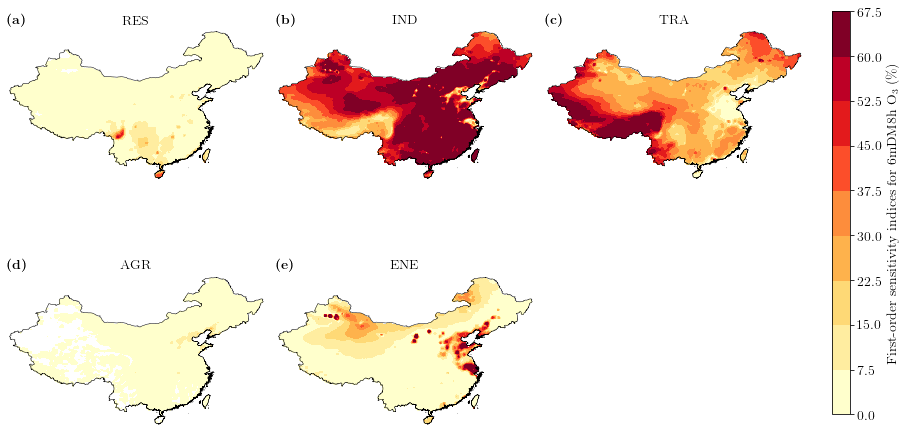

In [25]:
# first order sensntivity index

fig = plt.figure(1, figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)

sens = 'S1'
region = 'China'

sims = ['RES', 'IND', 'TRA', 'AGR', 'ENE']
levels = {}
#levels.update({'China':(0,0.075,0.15,0.225,0.30,0.375,0.45,0.525,0.60,0.675,100000)})
#levels.update({'GBA':(0,0.075,0.15,0.225,0.30,0.375,0.45,0.525,0.60,0.675,100000)})
levels.update({'China':(0,7.5,15,22.5,30,37.5,45,52.5,60,67.5,100000)})
levels.update({'GBA':(0,7.5,15,22.5,30,37.5,45,52.5,60,67.5,100000)})
cmap_colors = {}
cmap_colors.update({'S1': ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']})
cb_label = {}
cb_label.update({'S1':'First-order sensitivity indices for ' + label + ' (\%)'})
plots = [(sim, sens, region, levels[region], cmap_colors[sens], cb_label[sens], label) for sim in sims]

for index, item in enumerate(plots):
    ax = fig.add_subplot(gs[index], projection=ccrs.PlateCarree())
    if item[2] == 'China':
        ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
        shape_feature = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp').geometries(),
                                       ccrs.PlateCarree(), facecolor='none')
        ax.patch.set_visible(False)
        ax.spines['geo'].set_visible(False)
        ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
    elif item[2] == 'GBA':
        ax.set_extent([111.3, 115.5, 21.5, 24.5], crs=ccrs.PlateCarree())
        shape_feature1 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_2.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature2 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/hongkong/gadm36_HKG_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature3 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/macao/gadm36_MAC_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature4 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/taiwan/gadm36_TWN_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        ax.add_feature(shape_feature1, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature2, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature3, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature4, edgecolor='black', linewidth=0.5)
    norm = matplotlib.colors.Normalize(vmin=item[3][0], vmax=item[3][-2])
    cmap = matplotlib.colors.ListedColormap(list(item[4]))
    im = ax.contourf(xx, yy, 100 * ds_sens_ind[item[1] + '_' + item[0]].values, item[3],
                     cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    plt.annotate(r'\textbf{(' + chr(97 + index) + ')}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)
    plt.title(item[0], size=14)

fig.canvas.draw()
gs.tight_layout(fig, rect=[0, 0, 0.95, 0.95], h_pad=1, w_pad=1) 

plt.draw()
    
ax_cbar = fig.add_axes([0.97, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=levels[region][0], vmax=levels[region][-2]),                       
    cmap=im.cmap
)
sm.set_array([])  
cb = plt.colorbar(
    sm, 
    cax=ax_cbar, 
    norm=matplotlib.colors.Normalize(vmin=levels[region][0], vmax=levels[region][-2]),              
    cmap=cmap_colors[sens], 
    ticks=levels[region][0:-1]
)
cb.set_label(cb_label[sens], size=14)
cb.ax.tick_params(labelsize=14)

#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/{output}_{region}_compare.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/{output}_{region}_compare.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [150]:
conc = xr.open_dataset(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/{output}_scaled/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_{output}_popgrid_0.25deg_scaled.nc')[output]

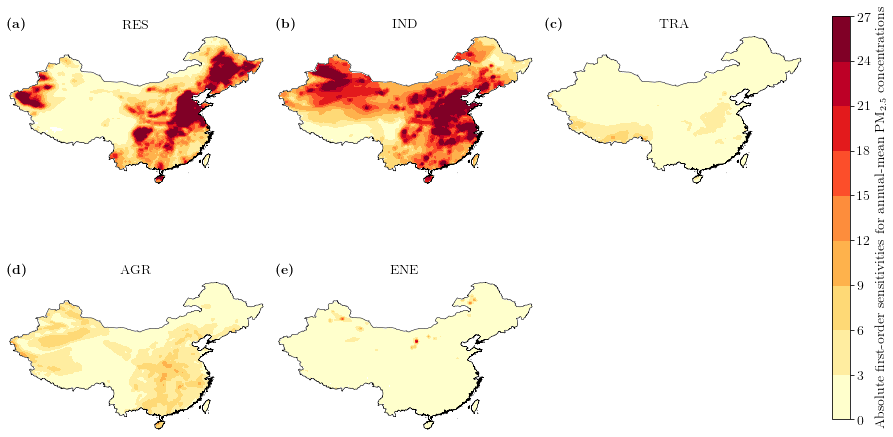

In [151]:
# absolute sensitivity

fig = plt.figure(1, figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)

sens = 'S1'
region = 'China'

sims = ['RES', 'IND', 'TRA', 'AGR', 'ENE']
levels = {}
levels.update({'China_PM2_5_DRY':np.linspace(0, 30, 11)})
levels.update({'GBA_PM2_5_DRY':np.linspace(0, 30, 11)})
levels.update({'China_o3_6mDM8h':np.linspace(0, 45, 11)})
levels.update({'GBA_o3_6mDM8h':(0,2.5,5,7.5,10,12.5,15,17.5,20,22.5,100000)})
levels.update({'China_AOD550_sfc':(0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,100000)})
levels.update({'GBA_AOD550_sfc':(0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,100000)})
levels.update({'China_asoaX_2p5':(0,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,100000)})
levels.update({'GBA_asoaX_2p5':(0,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,100000)})
levels.update({'China_bc_2p5':(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,100000)})
levels.update({'GBA_bc_2p5':(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,100000)})
levels.update({'China_bsoaX_2p5':(0,0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,100000)})
levels.update({'GBA_bsoaX_2p5':(0,0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,100000)})
levels.update({'China_nh4_2p5':(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,100000)})
levels.update({'GBA_nh4_2p5':(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,100000)})
levels.update({'China_no3_2p5':(0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,100000)})
levels.update({'GBA_no3_2p5':(0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,100000)})
levels.update({'China_oc_2p5':(0,1,2,3,4,5,6,7,8,9,100000)})
levels.update({'GBA_oc_2p5':(0,1,2,3,4,5,6,7,8,9,100000)})
levels.update({'China_oin_2p5':(0,1,2,3,4,5,6,7,8,9,100000)})
levels.update({'GBA_oin_2p5':(0,1,2,3,4,5,6,7,8,9,100000)})
levels.update({'China_so4_2p5':(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,100000)})
levels.update({'GBA_so4_2p5':(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,100000)})
cmap_colors = {}
cmap_colors.update({'S1': ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']})
cb_label = {}
cb_label.update({'S1':'Absolute first-order sensitivities for ' + label})
plots = [(sim, sens, region, levels[region + '_' + output], cmap_colors[sens], cb_label[sens], label) for sim in sims]

for index, item in enumerate(plots):
    ax = fig.add_subplot(gs[index], projection=ccrs.PlateCarree())
    if item[2] == 'China':
        ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
        shape_feature = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp').geometries(),
                                       ccrs.PlateCarree(), facecolor='none')
        ax.patch.set_visible(False)
        ax.spines['geo'].set_visible(False)
        ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
    elif item[2] == 'GBA':
        ax.set_extent([111.3, 115.5, 21.5, 24.5], crs=ccrs.PlateCarree())
        shape_feature1 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_2.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature2 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/hongkong/gadm36_HKG_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature3 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/macao/gadm36_MAC_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        shape_feature4 = ShapelyFeature(Reader('/nfs/a68/earlacoa/shapefiles/taiwan/gadm36_TWN_0.shp').geometries(),
                                        ccrs.PlateCarree(), facecolor='none')
        ax.add_feature(shape_feature1, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature2, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature3, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape_feature4, edgecolor='black', linewidth=0.5)
    norm = matplotlib.colors.Normalize(vmin=item[3][0], vmax=item[3][-2])
    cmap = matplotlib.colors.ListedColormap(list(item[4]))
    im = ax.contourf(xx, yy, ds_sens_ind[item[1] + '_' + item[0]].values * conc.values, item[3],
                     cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), extend='max')
    plt.annotate(r'\textbf{(' + chr(97 + index) + ')}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)
    plt.title(item[0], size=14)

fig.canvas.draw()
gs.tight_layout(fig, rect=[0, 0, 0.95, 0.95], h_pad=1, w_pad=1) 

plt.draw()
    
ax_cbar = fig.add_axes([0.97, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=levels[region + '_' + output][0], vmax=levels[region + '_' + output][-2]),                       
    cmap=im.cmap
)
sm.set_array([])  
cb = plt.colorbar(
    sm, 
    cax=ax_cbar, 
    norm=matplotlib.colors.Normalize(vmin=levels[region + '_' + output][0], vmax=levels[region + '_' + output][-2]),              
    cmap=cmap_colors[sens], 
    ticks=levels[region + '_' + output][0:-1]
)
cb.set_label(cb_label[sens], size=14)
cb.ax.tick_params(labelsize=14)

plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/{output}_compare_abs_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/{output}_compare_abs_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [ ]:
# crop sensitivities per region
regions = {
    'china': '/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp',
    'gba': '/nfs/a68/earlacoa/shapefiles/china/gba.shp',
    'china_north': '/nfs/a68/earlacoa/shapefiles/china/CHN_north.shp',
    'china_north_east': '/nfs/a68/earlacoa/shapefiles/china/CHN_north_east.shp',
    'china_east': '/nfs/a68/earlacoa/shapefiles/china/CHN_east.shp',
    'china_south_central': '/nfs/a68/earlacoa/shapefiles/china/CHN_south_central.shp',
    'china_south_west': '/nfs/a68/earlacoa/shapefiles/china/CHN_south_west.shp',
    'china_north_west': '/nfs/a68/earlacoa/shapefiles/china/CHN_north_west.shp'
}
sensitivities = ['S1', 'S2', 'ST']
sims = ['RES', 'IND', 'TRA', 'AGR', 'ENE']
sims_S2 = ['RES_IND', 'RES_TRA', 'RES_AGR', 'RES_ENE', 'IND_TRA', 'IND_AGR', 'IND_ENE', 'TRA_AGR', 'TRA_ENE', 'AGR_ENE']

In [ ]:
sens_cropped = {}
    
for sens in ['S1', 'ST']:
    for sim in sims:
        sens_array = ds_sens_ind[f'{sens}_{sim}'].copy()
        for region, shapefile in regions.items():
            shp = gpd.read_file(shapefile)
            shapes = [(shape, n) for n, shape in enumerate(shp.geometry)]
            clip = rasterize(shapes, sens_array.coords, longitude='lon', latitude='lat')
            clipped_ds = sens_array.where(clip==0, other=np.nan)
            sens_cropped.update({f'{output}_{sens}_{sim}_{region}': np.nanmean(clipped_ds)})
            
            
sens = 'S2'
for sim in sims_S2:
    sens_array = ds_sens_ind[f'{sens}_{sim}'].copy()
    for region, shapefile in regions.items():
        shp = gpd.read_file(shapefile)
        shapes = [(shape, n) for n, shape in enumerate(shp.geometry)]
        clip = rasterize(shapes, sens_array.coords, longitude='lon', latitude='lat')
        clipped_ds = sens_array.where(clip==0, other=np.nan)
        sens_cropped.update({f'{output}_{sens}_{sim}_{region}': np.nanmean(clipped_ds)})

In [ ]:
[(key, round(100 * value, 0)) for key, value in sens_cropped.items() if 'S1' in key]

In [ ]:
[(key, round(100 * value, 0)) for key, value in sens_cropped.items() if 'S2' in key if abs(round(100 * value, 0)) > 1.0]

#### control for all outputs and regions

In [ ]:
outputs = [
    'PM2_5_DRY',
    'o3_6mDM8h',
    'AOD550_sfc',
    'asoaX_2p5',
    'bc_2p5',
    'bsoaX_2p5',
    'nh4_2p5',
    'no3_2p5',
    'oc_2p5',
    'oin_2p5',
    'so4_2p5'
]

regions = {
    'china': '/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp',
    'gba': '/nfs/a68/earlacoa/shapefiles/china/gba.shp',
    'china_north': '/nfs/a68/earlacoa/shapefiles/china/CHN_north.shp',
    'china_north_east': '/nfs/a68/earlacoa/shapefiles/china/CHN_north_east.shp',
    'china_east': '/nfs/a68/earlacoa/shapefiles/china/CHN_east.shp',
    'china_south_central': '/nfs/a68/earlacoa/shapefiles/china/CHN_south_central.shp',
    'china_south_west': '/nfs/a68/earlacoa/shapefiles/china/CHN_south_west.shp',
    'china_north_west': '/nfs/a68/earlacoa/shapefiles/china/CHN_north_west.shp'
}

In [ ]:
with xr.open_dataset('/nfs/a68/earlacoa/population/count/v4.11/2015/gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-2015-qtr-deg.nc') as ds:
    pop_2015 = ds['pop']

pop_2015_clipped = {}

for region, shapefile in regions.items():
    shp = gpd.read_file(shapefile)
    shapes = [(shape, n) for n, shape in enumerate(shp.geometry)]
    clip = rasterize(shapes, pop_2015.coords, longitude='lon', latitude='lat')
    pop_2015_clipped.update({region: pop_2015.where(clip==0, other=np.nan)})

In [ ]:
ctls = {}

for output in outputs:
    with xr.open_dataset(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/{output}_scaled/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_{output}_popgrid_0.25deg_scaled.nc') as ds:
        ds_ctl_output = ds[output]
        
    for region, shapefile in regions.items():
        shp = gpd.read_file(shapefile)
        shapes = [(shape, n) for n, shape in enumerate(shp.geometry)]
        clip = rasterize(shapes, ds_ctl_output.coords, longitude='lon', latitude='lat')
        clipped_ds = ds_ctl_output.where(clip==0, other=np.nan)
        if output == 'PM2_5_DRY':
            ctls.update({f'{output}_{region}_popweighted': np.nansum((clipped_ds * pop_2015) / pop_2015_clipped[region].sum())})
        ctls.update({f'{output}_{region}': np.nanmean(clipped_ds)})


In [ ]:
joblib.dump(ctls, f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/ctl_all_outputs_individual_inputs_region_{output}_scaled.joblib')

In [ ]:
low_scenarios = [
    'RES0.0_IND0.0_TRA0.2_AGR0.7_ENE0.0',
    'RES0.0_IND0.0_TRA0.0_AGR0.0_ENE0.8',
    'RES0.0_IND0.0_TRA0.3_AGR0.7_ENE0.0',
    'RES0.0_IND0.0_TRA0.4_AGR0.7_ENE0.0',
    'RES0.0_IND0.0_TRA0.1_AGR0.5_ENE0.0',
    'RES0.0_IND0.0_TRA0.5_AGR0.0_ENE0.8',
    'RES0.0_IND0.0_TRA0.0_AGR0.7_ENE0.0'
]

scenarios = {}

for output in outputs:
    for low_scenario in low_scenarios:
        with xr.open_dataset(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/{output}_scaled/ds_{low_scenario}_{output}_popgrid_0.25deg_scaled.nc') as ds:
            ds_output = ds[output]

        for region, shapefile in regions.items():
            shp = gpd.read_file(shapefile)
            shapes = [(shape, n) for n, shape in enumerate(shp.geometry)]
            clip = rasterize(shapes, ds_output.coords, longitude='lon', latitude='lat')
            clipped_ds = ds_output.where(clip==0, other=np.nan)
            if output == 'PM2_5_DRY':
                scenarios.update({f'{output}_{region}_{low_scenario}_popweighted': np.nansum((clipped_ds * pop_2015) / pop_2015_clipped[region].sum())})
            scenarios.update({f'{output}_{region}_{low_scenario}': np.nanmean(clipped_ds)})


In [ ]:
joblib.dump(scenarios, f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/scenarios_all_outputs_individual_inputs_region_{output}_scaled.joblib')

In [ ]:
outputs = [
    'asoaX_2p5',
    'bc_2p5',
    'bsoaX_2p5',
    'nh4_2p5',
    'no3_2p5',
    'oc_2p5',
    'oin_2p5',
    'so4_2p5',
    'other'
]

for region in regions:
    print()
    print(region)
    perc_sum = 0.0
    for output in outputs:
        print()
        print(output)
        if output != 'other':    
            perc = 100 * ctls[f'{output}_{region}'] / ctls[f'PM2_5_DRY_{region}']
            perc_sum += perc
            print('perc: ', round(perc, 2))
        else:
            print('perc: ', round(100 - perc_sum, 2))

In [ ]:
regions = [
#    'china',
#    'gba',
#    'china_north',
#    'china_north_east',
#    'china_east',
#    'china_south_central',
    'china_south_west',
#    'china_north_west'
]
outputs = [
    'PM2_5_DRY',
    'asoaX_2p5',
    'bc_2p5',
    'bsoaX_2p5',
    'nh4_2p5',
    'no3_2p5',
    'oc_2p5',
    'oin_2p5',
    'so4_2p5',
    'other'
]

low_scenarios = [
#    'RES0.0_IND0.0_TRA0.2_AGR0.7_ENE0.0',
#    'RES0.0_IND0.0_TRA0.0_AGR0.0_ENE0.8',
#    'RES0.0_IND0.0_TRA0.3_AGR0.7_ENE0.0',
#    'RES0.0_IND0.0_TRA0.4_AGR0.7_ENE0.0',
#    'RES0.0_IND0.0_TRA0.2_AGR0.7_ENE0.0',
#    'RES0.0_IND0.0_TRA0.1_AGR0.5_ENE0.0',
    'RES0.0_IND0.0_TRA0.5_AGR0.0_ENE0.8',
#    'RES0.0_IND0.0_TRA0.0_AGR0.7_ENE0.0'
]

for index, region in enumerate(regions):
    ctl_perc_sum = 0
    new_perc_sum = 0
    print()
    print(region)
    for output in outputs:
        print()
        print(output)
        low_scenario = low_scenarios[index]
        print()
        print(low_scenario)
        if output == 'PM2_5_DRY':
            print('ctl: ', round(ctls[f'{output}_{region}_popweighted'], 1))
            print('new: ', round(scenarios[f'{output}_{region}_{low_scenario}_popweighted'], 1))    
            print('diff perc: ', int(100 * (scenarios[f'{output}_{region}_{low_scenario}_popweighted'] - ctls[f'{output}_{region}_popweighted']) / ctls[f'{output}_{region}_popweighted']))
        else:
            if output != 'other':
                ctl = ctls[f'{output}_{region}']
                new = scenarios[f'{output}_{region}_{low_scenario}']
                ctl_perc = 100 * ctl / ctls[f'PM2_5_DRY_{region}']
                new_perc = 100 * new / scenarios[f'PM2_5_DRY_{region}_{low_scenario}']
                ctl_perc_sum += ctl_perc
                new_perc_sum += new_perc
                print('ctl: ', round(ctl, 2))
                print('new: ', round(new, 2))
                print('ctl perc: ', round(ctl_perc, 2))
                print('new perc: ', round(new_perc, 2))
#                print('new perc: ', round(scenarios[f'{output}_{region}_{low_scenario}'], 1))
#                print('diff perc: ', int(100 * (scenarios[f'{output}_{region}_{low_scenario}'] - ctls[f'{output}_{region}']) / ctls[f'{output}_{region}']))
#                print('perc: ', round(perc, 2))
            else:
                print('ctl perc: ', round(100 - ctl_perc_sum, 2))
                print('new perc: ', round(100 - new_perc_sum, 2))


#### predicted output map for input config

##### specific config

In [155]:
#output = 'PM2_5_DRY'
output = 'o3_6mDM8h'
ds_ctl_output = xr.open_dataset(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/{output}_scaled/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_{output}_popgrid_0.25deg_scaled.nc')[output]

lat = ds_ctl_output.lat.values
lon = ds_ctl_output.lon.values
xx, yy = np.meshgrid(lon, lat)

In [156]:
regions = {
    'china': '/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp',
    'gba': '/nfs/a68/earlacoa/shapefiles/china/gba.shp',
    'china_north': '/nfs/a68/earlacoa/shapefiles/china/CHN_north.shp',
    'china_north_east': '/nfs/a68/earlacoa/shapefiles/china/CHN_north_east.shp',
    'china_east': '/nfs/a68/earlacoa/shapefiles/china/CHN_east.shp',
    'china_south_central': '/nfs/a68/earlacoa/shapefiles/china/CHN_south_central.shp',
    'china_south_west': '/nfs/a68/earlacoa/shapefiles/china/CHN_south_west.shp',
    'china_north_west': '/nfs/a68/earlacoa/shapefiles/china/CHN_north_west.shp'
}

with xr.open_dataset('/nfs/a68/earlacoa/population/count/v4/2015/gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-2015-qtr-deg.nc') as ds:
    pop_2015 = ds['pop'].load()

pop_2015_clipped = {}

for region, shapefile in regions.items():
    shp = gpd.read_file(shapefile)
    shapes = [(shape, n) for n, shape in enumerate(shp.geometry)]
    clip = rasterize(shapes, pop_2015.coords, longitude='lon', latitude='lat')
    pop_2015_clipped.update({region: pop_2015.where(clip==0, other=np.nan)})

In [157]:
filenames = [
    'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0',
#    'RES0.7_IND1.0_TRA1.0_AGR1.0_ENE1.0',
#    'RES1.0_IND0.7_TRA1.0_AGR1.0_ENE1.0'
]

popweighted = {}

for filename in filenames:
    ds_custom_output = xr.open_dataset(
        f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/{output}_scaled/ds_{filename}_{output}_popgrid_0.25deg_scaled.nc'
    )[output].load().reset_coords(drop=True)
    for region, shapefile in regions.items():
        shp = gpd.read_file(shapefile)
        shapes = [(shape, n) for n, shape in enumerate(shp.geometry)]
        clip = rasterize(shapes, ds_custom_output.coords, longitude='lon', latitude='lat')
        clipped_ds = ds_custom_output.where(clip==0, other=np.nan)
        popweighted.update({f'{output}_{region}_popweighted_{filename}': round(np.nansum((clipped_ds * pop_2015) / pop_2015_clipped[region].sum()), 1)})

        
popweighted

{'o3_6mDM8h_china_popweighted_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0': 43.3,
 'o3_6mDM8h_gba_popweighted_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0': 31.1,
 'o3_6mDM8h_china_north_popweighted_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0': 49.4,
 'o3_6mDM8h_china_north_east_popweighted_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0': 40.8,
 'o3_6mDM8h_china_east_popweighted_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0': 44.0,
 'o3_6mDM8h_china_south_central_popweighted_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0': 40.5,
 'o3_6mDM8h_china_south_west_popweighted_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0': 42.3,
 'o3_6mDM8h_china_north_west_popweighted_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0': 45.2}

In [ ]:
var = popweighted[f'{output}_china_popweighted_RES0.7_IND1.0_TRA1.0_AGR1.0_ENE1.0']
ctl = popweighted[f'{output}_china_popweighted_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
print(int(round(((100 * var / ctl) - 100), 0)), '%')
print(round((ctl - var), 1), 'ugm-3')

In [ ]:
var = popweighted[f'{output}_china_popweighted_RES1.0_IND0.7_TRA1.0_AGR1.0_ENE1.0']
ctl = popweighted[f'{output}_china_popweighted_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
print(int(round(((100 * var / ctl) - 100), 0)), '%')
print(round((ctl - var), 1), 'ugm-3')

In [ ]:
for region, shapefile in regions.items():
    var = popweighted[f'{output}_{region}_popweighted_RES0.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
    ctl = popweighted[f'{output}_{region}_popweighted_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
    #print(region, 100 - (100 * var / ctl))
    print(region, var)

In [ ]:
fig = plt.figure(1, figsize=(8, 4))
gs = gridspec.GridSpec(1, 2)

colors = ['teal', '#9ebcda', '#d95f0e', 'olive', '#8856a7']
labels = ['RES','IND', 'TRA', 'AGR', 'ENE']
annotate_x_locs = [0.13, 0.32, 0.51, 0.69, 0.88]

region = 'china'
var_plot_ctl = popweighted[f'{output}_{region}_popweighted_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
ax = fig.add_subplot(gs[0])
plt.annotate(r'\textbf{a}', xy=(0,1.05), xycoords='axes fraction', fontsize=14, weight='bold')
ax.set_facecolor('whitesmoke')
plt.subplots_adjust(bottom=0.3)
plt.yticks(fontsize=14)
plt.xlabel('30{\%} reduction per emission sector', fontsize=14)
plt.ylabel('Ambient PM$_{2.5}$ exposure (${\mu}g$ $m^{-3}$)', fontsize=14)
plt.title('China\n2015 baseline = ' + str(int(var_plot_ctl)) + ' ${\mu}g$ $m^{-3}$', fontsize=14)
plt.xticks(np.arange(5), fontsize=14)
ax.xaxis.set_ticklabels(labels)
plt.axhline(0, c='lightgrey')
for index, filename in enumerate(filenames[1:]):
    var_plot = popweighted[f'{output}_{region}_popweighted_{filename}']
    plt.bar(
        index, var_plot - var_plot_ctl,
        align='center', color=colors[index], width=0.8, alpha=0.7, label=labels[index]
    )
    plt.annotate(
        r'\textbf{' + str(np.int(np.rint(100 * ((var_plot / var_plot_ctl) - 1)))) + '$\%$' + '}',
        xy=(annotate_x_locs[index], 0.05), xycoords='axes fraction', fontsize=14, ha='center'
    )
    
region = 'gba'
var_plot_ctl = popweighted[f'{output}_{region}_popweighted_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
ax = fig.add_subplot(gs[1])
plt.annotate(r'\textbf{b}', xy=(0,1.05), xycoords='axes fraction', fontsize=14, weight='bold')
ax.set_facecolor('whitesmoke')
plt.subplots_adjust(bottom=0.3)
plt.yticks(fontsize=14)
plt.xlabel('30{\%} reduction per emission sector', fontsize=14)
plt.ylabel('Annual-mean PM$_{2.5}$ exposure (${\mu}g$ $m^{-3}$)', fontsize=14)
plt.title('GBA\nJan 2015  baseline = ' + str(int(var_plot_ctl)) + ' ${\mu}g$ $m^{-3}$', fontsize=14)
plt.xticks(np.arange(5), fontsize=14)
ax.xaxis.set_ticklabels(labels)
plt.axhline(0, c='lightgrey')
for index, filename in enumerate(filenames[1:]):
    var_plot = popweighted[f'{output}_{region}_popweighted_{filename}']
    plt.bar(
        index, var_plot - var_plot_ctl,
        align='center', color=colors[index], width=0.8, alpha=0.7, label=labels[index]
    )
    plt.annotate(
        r'\textbf{' + str(np.int(np.rint(100 * ((var_plot / var_plot_ctl) - 1)))) + '$\%$' + '}',
        xy=(annotate_x_locs[index], 0.05), xycoords='axes fraction', fontsize=14, ha='center'
    )

fig.canvas.draw()
gs.tight_layout(fig, rect=[0, 0, 1.0, 1.0])

#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/aia_final_report_30perred_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/aia_final_report_30perred_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

##### plot ctl

In [13]:
outputs = [
    'PM2_5_DRY',
    'o3_6mDM8h',
    'AOD550_sfc',
    'asoaX_2p5',
    'bc_2p5',
    'bsoaX_2p5',
    'nh4_2p5',
    'no3_2p5',
    'oc_2p5',
    'oin_2p5',
    'so4_2p5'
]

labels = [
    'Annual-mean PM$_{2.5}$ concentrations', 
    '6mDM8h O$_{3}$ concentrations', 
    'Surface AOD 550 nm', 
    'Anthropogenic SOA concentrations', 
    'BC concentrations', 
    'Biogenic SOA concentrations', 
    'NH$_{4}$ concentrations', 
    'NO$_{3}$ concentrations', 
    'OC concentrations', 
    'OIN concentrations', 
    'SO$_{4}$ concentrations'
]

cb_labels = {}

for index, output in enumerate(outputs):
    cb_label = labels[index]
        
    if output == 'o3':
        cb_label = cb_label + ' '
    elif output == 'AOD550_sfc':
        cb_label = cb_label
    else:
        cb_label = cb_label + ' (${\mu}g$ $m^{-3}$)'
        
    cb_labels.update({output: cb_label})

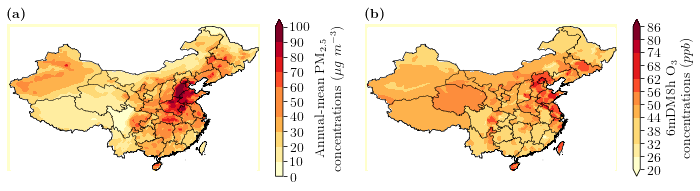

In [21]:
fig = plt.figure(1, figsize=(10, 5))
gs = gridspec.GridSpec(1, 2)

# a
output = 'PM2_5_DRY'
ds_ctl_output = xr.open_dataset(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/{output}_scaled/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_{output}_popgrid_0.25deg_scaled.nc')[output]
lat = ds_ctl_output.lat.values
lon = ds_ctl_output.lon.values
xx, yy = np.meshgrid(lon, lat)

ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
levels = np.linspace(0, 100, 11)
cmap = matplotlib.colors.ListedColormap(
    ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
)
plt.annotate(r'\textbf{(a)}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)
ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
shape_feature = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp').geometries(),                             
    ccrs.PlateCarree(), 
    facecolor='none'
)
shape2_feature = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_1.shp').geometries(),                             
    ccrs.PlateCarree(), 
    facecolor='none'
)
ax.patch.set_visible(False)
ax.spines['geo'].set_visible(False)
ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
ax.add_feature(shape2_feature, edgecolor='black', linewidth=0.3)
norm = matplotlib.colors.Normalize(
    vmin=levels[0], 
    vmax=levels[-1]
)
cmap = matplotlib.colors.ListedColormap(
    ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
)
im = ax.contourf(
    xx, 
    yy, 
    ds_ctl_output, 
    levels,
    cmap=cmap, 
    norm=norm, 
    transform=ccrs.PlateCarree(), extend='max'
)
cb = plt.colorbar(im, norm=norm, cmap=cmap, ticks=levels, shrink=0.47)
cb.set_label('Annual-mean PM$_{2.5}$\nconcentrations (${\mu}g$ $m^{-3}$)', size=14)
cb.ax.tick_params(labelsize=14)

# b
output = 'o3_6mDM8h'
ds_ctl_output = xr.open_dataset(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/{output}_scaled/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_{output}_popgrid_0.25deg_scaled.nc')[output]

ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
levels = np.linspace(20, 86, 12)
cmap = matplotlib.colors.ListedColormap(
    ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
)
plt.annotate(r'\textbf{(b)}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)
ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
shape_feature = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp').geometries(),                             
    ccrs.PlateCarree(), 
    facecolor='none'
)
shape2_feature = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_1.shp').geometries(),                             
    ccrs.PlateCarree(), 
    facecolor='none'
)
ax.patch.set_visible(False)
ax.spines['geo'].set_visible(False)
ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
ax.add_feature(shape2_feature, edgecolor='black', linewidth=0.3)
norm = matplotlib.colors.Normalize(
    vmin=levels[0], 
    vmax=levels[-1]
)
cmap = matplotlib.colors.ListedColormap(
    ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
)
im = ax.contourf(
    xx, 
    yy, 
    ds_ctl_output, 
    levels,
    cmap=cmap, 
    norm=norm, 
    transform=ccrs.PlateCarree(), extend='both'
)
cb = plt.colorbar(im, norm=norm, cmap=cmap, ticks=levels, shrink=0.47)
cb.set_label('6mDM8h O$_{3}$\nconcentrations ($ppb$)', size=14)
cb.ax.tick_params(labelsize=14)

gs.tight_layout(fig) # rect=[0, 0, 0.95, 0.95]

plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/ctl_pm25_o3_china-only_provinces_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/ctl_pm25_o3_china-only_provinces_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

##### plot diff

In [ ]:
ds_custom_diff = ds_custom_output - ds_ctl_output

In [ ]:
ds_custom_diff.max()

In [ ]:
max_value = ds_custom_diff.max().values * 0.9
min_value = ds_custom_diff.min().values * 0.9
if abs(max_value) > abs(min_value):
    value = abs(max_value)
else:
    value = abs(min_value)

increment = np.round(np.linspace(-value, value, 12)[-1] - np.linspace(-value, value, 12)[-2], decimals=1)
levels = np.linspace(-5.5 * increment, 5.5 * increment, 12)
levels = np.insert(levels, 0, -1000, axis=0)
levels = tuple([np.round(item, decimals=2) for item in np.append(levels, 1000)])
levels

In [ ]:
outputs = [
    'PM2_5_DRY',
    'o3_6mDM8h',
    'AOD550_sfc',
    'asoaX_2p5',
    'bc_2p5',
    'bsoaX_2p5',
    'nh4_2p5',
    'no3_2p5',
    'oc_2p5',
    'oin_2p5',
    'so4_2p5'
]

labels = [
    'Annual-mean PM$_{2.5}$ concentrations', 
    '6mDM8h O$_{3}$ concentrations', 
    'Surface AOD 550 nm', 
    'Anthropogenic SOA concentrations', 
    'BC concentrations', 
    'Biogenic SOA concentrations', 
    'NH$_{4}$ concentrations', 
    'NO$_{3}$ concentrations', 
    'OC concentrations', 
    'OIN concentrations', 
    'SO$_{4}$ concentrations'
]

cb_labels = {}

for index, output in enumerate(outputs):
    cb_label = labels[index]
        
    if output == 'o3':
        cb_label = cb_label + ' (ppb)'
    elif output == 'AOD550_sfc':
        cb_label = cb_label
    else:
        cb_label = cb_label + ' (${\mu}g$ $m^{-3}$)'
        
    cb_labels.update({output: cb_label})

In [ ]:
fig = plt.figure(1, figsize=(10, 5))
gs = gridspec.GridSpec(1, 2)

output = 'o3'
# 'PM2_5_DRY', 'o3_6mDM8h'
# China
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
shape_feature = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp').geometries(),                             
    ccrs.PlateCarree(), 
    facecolor='none'
)
ax.patch.set_visible(False)
ax.spines['geo'].set_visible(False)
ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
norm = matplotlib.colors.Normalize(
    vmin=levels[1], 
    vmax=levels[-2]
)
cmap_colors = list(reversed(
    ['#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#f5f5f5', '#c7eae5', '#80cdc1', '#35978f', '#01665e', '#003c30']
))
cmap = matplotlib.colors.ListedColormap(cmap_colors)
im = ax.contourf(
    xx, 
    yy, 
    ds_custom_diff, 
    levels,
    cmap=cmap, 
    norm=norm, 
    transform=ccrs.PlateCarree()
)
plt.annotate(r'\textbf{a}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)

# GBA
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax.set_extent([111.3, 115.5, 21.5, 24.5], crs=ccrs.PlateCarree())
shape_feature1 = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_2.shp').geometries(),
    ccrs.PlateCarree(), 
    facecolor='none'
)
shape_feature2 = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/hongkong/gadm36_HKG_0.shp').geometries(),           
    ccrs.PlateCarree(), 
    facecolor='none'
)
shape_feature3 = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/macao/gadm36_MAC_0.shp').geometries(),      
    ccrs.PlateCarree(), 
    facecolor='none'
)
shape_feature4 = ShapelyFeature(
    Reader('/nfs/a68/earlacoa/shapefiles/taiwan/gadm36_TWN_0.shp').geometries(),              
    ccrs.PlateCarree(), 
    facecolor='none'
)
ax.add_feature(shape_feature1, edgecolor='black', linewidth=0.5)
ax.add_feature(shape_feature2, edgecolor='black', linewidth=0.5)
ax.add_feature(shape_feature3, edgecolor='black', linewidth=0.5)
ax.add_feature(shape_feature4, edgecolor='black', linewidth=0.5)
norm = matplotlib.colors.Normalize(
    vmin=levels[1], 
    vmax=levels[-2]
)
cmap_colors = list(reversed(
    ['#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#f5f5f5', '#c7eae5', '#80cdc1', '#35978f', '#01665e', '#003c30']
))
cmap = matplotlib.colors.ListedColormap(cmap_colors)
im = ax.contourf(
    xx, 
    yy, 
    ds_custom_diff, 
    levels,
    cmap=cmap, 
    norm=norm, 
    transform=ccrs.PlateCarree()
)
plt.annotate(r'\textbf{b}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)

# color bar
fig.canvas.draw()
gs.tight_layout(fig, rect=[0, 0, 0.95, 0.95], h_pad=1, w_pad=1) 

plt.draw()
    
ax_cbar = fig.add_axes([0.97, 0.15, 0.02, 0.65])
sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(
        vmin=levels[1], 
        vmax=levels[-2]
    ),                       
    cmap=im.cmap
)
sm.set_array([])  
cb = plt.colorbar(
    sm, 
    cax=ax_cbar, 
    norm=matplotlib.colors.Normalize(
        vmin=levels[1], 
        vmax=levels[-2]
    ),              
    cmap=cmap, 
    ticks=levels[1:-1]
)
cb.set_label(cb_labels[output], size=14)
cb.ax.tick_params(labelsize=14)

#plt.savefig('/nfs/a336/earlacoa/png/paper_aia_emulator_annual/custom_input_{output}_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/a336/earlacoa/png/paper_aia_emulator_annual/custom_input_{output}_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

#### line plot for individual emission sectors vs pop-weighted output

In [27]:
output = 'PM2_5_DRY'
#output = 'o3_6mDM8h'

ds_ctl_output = xr.open_dataset(
    f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/{output}_scaled/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_{output}_popgrid_0.25deg_scaled.nc'
)[output]
lat = ds_ctl_output.lat.values
lon = ds_ctl_output.lon.values
xx, yy = np.meshgrid(lon, lat)

In [28]:
with xr.open_dataset('/nfs/a68/earlacoa/population/count/v4/2015/gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-2015-qtr-deg.nc') as ds:
    pop_2015 = ds['pop']

In [29]:
matrix1 = np.array(np.meshgrid(np.linspace(0, 1.4, 8), 1, 1, 1, 1)).T.reshape(-1, 5)
matrix2 = np.array(np.meshgrid(1, np.linspace(0, 1.4, 8), 1, 1, 1)).T.reshape(-1, 5)
matrix3 = np.array(np.meshgrid(1, 1, np.linspace(0, 1.4, 8), 1, 1)).T.reshape(-1, 5)
matrix4 = np.array(np.meshgrid(1, 1, 1, np.linspace(0, 1.4, 8), 1)).T.reshape(-1, 5)
matrix5 = np.array(np.meshgrid(1, 1, 1, 1, np.linspace(0, 1.4, 8))).T.reshape(-1, 5)
matrix_stacked = np.vstack((matrix1, matrix2, matrix3, matrix4, matrix5))

In [30]:
regions = {
    'china': '/nfs/a68/earlacoa/shapefiles/china/china_taiwan_hongkong_macao.shp',
    'gba': '/nfs/a68/earlacoa/shapefiles/china/gba.shp',
    'china_north': '/nfs/a68/earlacoa/shapefiles/china/CHN_north.shp',
    'china_north_east': '/nfs/a68/earlacoa/shapefiles/china/CHN_north_east.shp',
    'china_east': '/nfs/a68/earlacoa/shapefiles/china/CHN_east.shp',
    'china_south_central': '/nfs/a68/earlacoa/shapefiles/china/CHN_south_central.shp',
    'china_south_west': '/nfs/a68/earlacoa/shapefiles/china/CHN_south_west.shp',
    'china_north_west': '/nfs/a68/earlacoa/shapefiles/china/CHN_north_west.shp'
}

In [31]:
pop_2015_clipped = {}

for region, shapefile in regions.items():
    shp = gpd.read_file(shapefile)
    shapes = [(shape, n) for n, shape in enumerate(shp.geometry)]
    clip = rasterize(shapes, pop_2015.coords, longitude='lon', latitude='lat')
    pop_2015_clipped.update({region: pop_2015.where(clip==0, other=np.nan)})

In [32]:
popweighted = {}

for matrix in matrix_stacked:
    custom_inputs = matrix.reshape(1, -1)
    filename = 'RES' + str(np.round(custom_inputs[0][0], decimals=1)) \
                + '_IND' + str(np.round(custom_inputs[0][1], decimals=1)) \
                + '_TRA' + str(np.round(custom_inputs[0][2], decimals=1)) \
                + '_AGR' + str(np.round(custom_inputs[0][3], decimals=1)) \
                + '_ENE' + str(np.round(custom_inputs[0][4], decimals=1))
    with xr.open_dataset(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions/{output}_scaled/ds_{filename}_{output}_popgrid_0.25deg_scaled.nc') as ds:
        ds_custom_output = ds[output]
        
    for region, shapefile in regions.items():
        shp = gpd.read_file(shapefile)
        shapes = [(shape, n) for n, shape in enumerate(shp.geometry)]
        clip = rasterize(shapes, ds_custom_output.coords, longitude='lon', latitude='lat')
        clipped_ds = ds_custom_output.where(clip==0, other=np.nan)
        popweighted.update({f'{region}_{output}_{filename}': np.nansum((clipped_ds * pop_2015) / pop_2015_clipped[region].sum())})

In [33]:
joblib.dump(popweighted, f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_individual_inputs_region_{output}_scaled.joblib')
joblib.dump(pop_2015_clipped, f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/pop_2015_region_{output}_scaled.joblib')

['/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/pop_2015_region_PM2_5_DRY_scaled.joblib']

In [156]:
popweighted = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_individual_inputs_region_{output}_scaled.joblib')
pop_2015_clipped = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/pop_2015_region_{output}_scaled.joblib')

In [45]:
def make_plot_exposure(index, output, outputs_popweighted, label, title):
    ax = fig.add_subplot(gs[index])
    ax.set_facecolor('whitesmoke')
    
    plt.xlim([0, 140])
    values = [item[1] for item in outputs_popweighted]
    plt.ylim([round(np.nanmin(values)) - 2, round(np.nanmax(values)) + 2])
    
    plt.xticks(np.arange(0, 160, 20), fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.xlabel('Percentage emissions ({\%})', fontsize=14)
    plt.ylabel(label, fontsize=14)
    
    plt.annotate(r'\textbf{(' + chr(97 + index) + ')}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)
    plt.title(title, fontsize=14)
    
    if output == 'PM2_5_DRY':
        plt.axhline(10, c='lightgrey')
        plt.axhline(15, c='lightgrey')
        plt.axhline(25, c='lightgrey')
        plt.axhline(35, c='lightgrey')
    elif output == 'o3_6mDM8h':
        plt.axhline(50, c='lightgrey')
        plt.axhline(80, c='lightgrey')
    
    res = {}
    ind = {}
    tra = {}
    agr = {}
    ene = {}

    for key, value in outputs_popweighted:
        if 'IND1.0_TRA1.0_AGR1.0_ENE1.0' in key:
            sim = 'RES'
            emission_factor = float(re.findall(r'\d+\.\d+', re.findall(r'' + sim + '\d+\.\d+', key)[0])[0]) * 100
            res.update({emission_factor: value})
        elif 'TRA1.0_AGR1.0_ENE1.0' in key and 'RES1.0' in key:
            sim = 'IND'
            emission_factor = float(re.findall(r'\d+\.\d+', re.findall(r'' + sim + '\d+\.\d+', key)[0])[0]) * 100
            ind.update({emission_factor: value})
        elif 'AGR1.0_ENE1.0' in key and 'RES1.0_IND1.0' in key:
            sim = 'TRA'
            emission_factor = float(re.findall(r'\d+\.\d+', re.findall(r'' + sim + '\d+\.\d+', key)[0])[0]) * 100
            tra.update({emission_factor: value})
        elif 'ENE1.0' in key and 'RES1.0_IND1.0_TRA1.0' in key:
            sim = 'AGR'
            emission_factor = float(re.findall(r'\d+\.\d+', re.findall(r'' + sim + '\d+\.\d+', key)[0])[0]) * 100
            agr.update({emission_factor: value})
        elif 'RES1.0_IND1.0_TRA1.0_AGR1.0' in key:
            sim = 'ENE'
            emission_factor = float(re.findall(r'\d+\.\d+', re.findall(r'' + sim + '\d+\.\d+', key)[0])[0]) * 100
            ene.update({emission_factor: value})
    
    plt.plot(list(res.keys()), list(res.values()), '-o', color='teal')
    plt.plot(list(ind.keys()), list(ind.values()), '-o', color='#8856a7')
    plt.plot(list(tra.keys()), list(tra.values()), '-o', color='#d95f0e')
    plt.plot(list(agr.keys()), list(agr.values()), '-o', color='olive')
    plt.plot(list(ene.keys()), list(ene.values()), '-o', color='grey')

In [39]:
#output = 'PM2_5_DRY'
#label = 'Annual-mean PM$_{2.5}$ exposure (${\\mu}g$ $m^{-3}$)'

output = 'o3_6mDM8h'
label = '6mDM8h O$_{3}$ exposure ($ppb$)'

ValueError: zero-size array to reduction operation minimum which has no identity

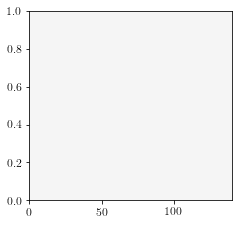

In [40]:
fig = plt.figure(1, figsize=(8, 16))
gs = gridspec.GridSpec(4, 2)

make_plot_exposure(0, output, [item for item in popweighted.items() if 'china_' + output in item[0]], label, 'China')
make_plot_exposure(1, output, [item for item in popweighted.items() if 'gba_' + output in item[0]], label, 'GBA')
make_plot_exposure(2, output, [item for item in popweighted.items() if 'china_north_' + output in item[0]], label, 'North China')
make_plot_exposure(3, output, [item for item in popweighted.items() if 'china_north_east_' + output in item[0]], label, 'North East China')
make_plot_exposure(4, output, [item for item in popweighted.items() if 'china_east_' + output in item[0]], label, 'East China')
make_plot_exposure(5, output, [item for item in popweighted.items() if 'china_south_central_' + output in item[0]], label, 'South Central China')
make_plot_exposure(6, output, [item for item in popweighted.items() if 'china_south_west_' + output in item[0]], label, 'South West China')
make_plot_exposure(7, output, [item for item in popweighted.items() if 'china_north_west_' + output in item[0]], label, 'North West China')

leg_1 = matplotlib.lines.Line2D([], [], color='teal', linewidth=8.0, label=r'\textbf{RES}', alpha=0.7)
leg_2 = matplotlib.lines.Line2D([], [], color='#8856a7', linewidth=8.0, label=r'\textbf{IND}', alpha=0.7)
leg_3 = matplotlib.lines.Line2D([], [], color='#d95f0e', linewidth=8.0, label=r'\textbf{TRA}', alpha=0.7)
leg_4 = matplotlib.lines.Line2D([], [], color='olive', linewidth=8.0, label=r'\textbf{AGR}', alpha=0.7)
leg_5 = matplotlib.lines.Line2D([], [], color='grey', linewidth=8.0, label=r'\textbf{ENE}', alpha=0.7)

gs.tight_layout(fig, rect=[0, 0, 1.0, 1.0])

bb = (fig.subplotpars.left + 0.06, fig.subplotpars.top + 0.03, fig.subplotpars.right - fig.subplotpars.left - 0.1, 0.1)
plt.legend(
    fontsize=12, fancybox=True, loc='upper center', bbox_to_anchor=bb, ncol=5, frameon=False,
    handles=[leg_1, leg_2, leg_3, leg_4, leg_5], mode='expand', borderaxespad=0., 
    bbox_transform=fig.transFigure
)

#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/{output}_line-plot_all_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/{output}_line-plot_all_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

### 2D contour plots
data created on arc4 using `emulator_prediction.bash`
then also regridded to population grid using `regrid_to_popgrid.bash`
then grouped by region using `popweighted_region.bash`

In [4]:
pm25_popweighted_china = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_china_PM2_5_DRY_0.25deg_scaled.joblib')
pm25_popweighted_gba = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_gba_PM2_5_DRY_0.25deg_scaled.joblib')
pm25_popweighted_china_north = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_china_north_PM2_5_DRY_0.25deg_scaled.joblib')
pm25_popweighted_china_north_east = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_china_north_east_PM2_5_DRY_0.25deg_scaled.joblib')
pm25_popweighted_china_east = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_china_east_PM2_5_DRY_0.25deg_scaled.joblib')
pm25_popweighted_china_south_central = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_china_south_central_PM2_5_DRY_0.25deg_scaled.joblib')
pm25_popweighted_china_south_west = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_china_south_west_PM2_5_DRY_0.25deg_scaled.joblib')
pm25_popweighted_china_north_west = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_china_north_west_PM2_5_DRY_0.25deg_scaled.joblib')

In [5]:
o3_popweighted_china = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_china_o3_6mDM8h_0.25deg_scaled.joblib')
o3_popweighted_gba = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_gba_o3_6mDM8h_0.25deg_scaled.joblib')
o3_popweighted_china_north = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_china_north_o3_6mDM8h_0.25deg_scaled.joblib')
o3_popweighted_china_north_east = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_china_north_east_o3_6mDM8h_0.25deg_scaled.joblib')
o3_popweighted_china_east = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_china_east_o3_6mDM8h_0.25deg_scaled.joblib')
o3_popweighted_china_south_central = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_china_south_central_o3_6mDM8h_0.25deg_scaled.joblib')
o3_popweighted_china_south_west = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_china_south_west_o3_6mDM8h_0.25deg_scaled.joblib')
o3_popweighted_china_north_west = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_china_north_west_o3_6mDM8h_0.25deg_scaled.joblib')

In [6]:
def extract_values(popweighted_values, fixed1, fixed2, fixed3):
    sublist = [item for item in popweighted_values if item != None if fixed1 in item[0] and fixed2 in item[0] and fixed3 in item[0]]
    z = np.array([item[1] for item in sublist])
    inputs_without_fixed = [re.sub(fixed1, '', re.sub(fixed2, '', re.sub(fixed3, '', item[0]))) for item in sublist]
    inputs = [np.array(re.findall(r'\d+\.\d+', item)).astype(float) for item in inputs_without_fixed]
    x = np.array([loc[0] for loc in inputs])
    y = np.array([loc[1] for loc in inputs])
    return x, y, z

In [55]:
outputs = ['pm25', 'o3']
regions = ['china', 'gba', 'china_north', 'china_north_east', 'china_east', 'china_south_central', 'china_south_west', 'china_north_west']
predictions = {
    'china_pm25': pm25_popweighted_china,
    'china_o3': o3_popweighted_china,
    'gba_pm25': pm25_popweighted_gba,
    'gba_o3': o3_popweighted_gba,
    'china_north_pm25': pm25_popweighted_china_north,
    'china_north_o3': o3_popweighted_china_north,
    'china_north_east_pm25': pm25_popweighted_china_north_east,
    'china_north_east_o3': o3_popweighted_china_north_east,
    'china_east_pm25': pm25_popweighted_china_east,
    'china_east_o3': o3_popweighted_china_east,
    'china_south_central_pm25': pm25_popweighted_china_south_central,
    'china_south_central_o3': o3_popweighted_china_south_central,
    'china_south_west_pm25': pm25_popweighted_china_south_west,
    'china_south_west_o3': o3_popweighted_china_south_west,
    'china_north_west_pm25': pm25_popweighted_china_north_west,
    'china_north_west_o3': o3_popweighted_china_north_west,
}
labels = {
    'pm25': 'annual-mean PM$_{2.5}$ exposure (${\\mu}g$ $m^{-3}$)',
    'o3': '6mDM8h O$_{3}$ exposure ($ppb$)'
}
region_labels = {
    'china': 'China',
    'gba': 'GBA',
    'china_north': 'North China',
    'china_north_east': 'North East China',
    'china_east': 'East China',
    'china_south_central': 'South Central China',
    'china_south_west': 'South West China',
    'china_north_west': 'North West China'
}

In [135]:
def make_plot(index, levels, x, y, z, x_label, y_label, output):
    ax = fig.add_subplot(gs[index])
    plt.xlim([0, 1.4])
    plt.ylim([0, 1.4])
    plt.xticks(np.arange(0, 1.6, 0.2))
    plt.yticks(np.arange(0, 1.6, 0.2))
    ax.set_xticklabels(np.arange(0, 160, 20))
    ax.set_yticklabels(np.arange(0, 160, 20))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Percentage emissions, " + x_label + " ({\%})", fontsize=14)
    plt.ylabel("Percentage emissions, " + y_label + " ({\%})", fontsize=14)
    norm = matplotlib.colors.Normalize(vmin=levels[0], vmax=levels[-1])
    cmap = 'viridis'
    im = ax.contourf( # filled contours
        x.reshape(8, 8), 
        y.reshape(8, 8), 
        z.reshape(8, 8), 
        levels, 
        cmap=cmap, 
        norm=norm,
        extend='max'
    )
    line_colors = ['black' for l in im.levels]
    cp = ax.contour( # black lines over contour gaps
        x.reshape(8, 8), 
        y.reshape(8, 8), 
        z.reshape(8, 8),
        levels=levels,
        colors=line_colors
    )
    if output == 'pm25':
        ax.clabel(cp, fontsize=14, colors=line_colors, fmt="%1.0f", rightside_up=True) # labels for contours
    if output == 'o3':
        ax.clabel(cp, fontsize=14, colors=line_colors, fmt="%1.0f", rightside_up=True) # labels for contours
    plt.annotate(r'\textbf{(' + chr(97 + index) + '})', xy=(0,1.05), xycoords='axes fraction', fontsize=14)

In [ ]:
for output in outputs:
    for region in regions:
        label = region_labels[region] + ', ' + labels[output]
        popweighted_values = predictions[region + '_' + output].copy()

        # plot
        fig = plt.figure(1, figsize=(12, 16))
        gs = gridspec.GridSpec(4, 3)

        x_labels = ['RES', 'RES', 'RES', 'RES', 'IND', 'IND', 'IND', 'TRA', 'TRA', 'AGR']
        y_labels = ['IND', 'TRA', 'AGR', 'ENE', 'TRA', 'AGR', 'ENE', 'AGR', 'ENE', 'ENE']
        values = [item[1] for item in popweighted_values if item != None]
        if output == 'pm25':
            min_level = (int(np.ceil(np.nanmin(values) / 5)) * 5) - 5
            max_level = int(np.ceil(np.nanmax(values) / 5)) * 5
            levels = np.linspace(min_level, max_level, 1 + (max_level - min_level) / 5)
        elif output == 'o3':
            min_level = (int(np.ceil(np.nanmin(values) / 2)) * 2) - 2
            max_level = int(np.ceil(np.nanmax(values) / 2)) * 2
            levels = np.linspace(min_level, max_level, 1 + (max_level - min_level))


        if output == 'pm25':
            ticks = [str(int(item)) for item in levels]
            for index, tick in enumerate(ticks):
                if tick == '10':
                    ticks[index] = '10 (WHO AQG)'
                if tick == '15':
                    ticks[index] = '15 (WHO IT-1)'
                if tick == '25':
                    ticks[index] = '25 (WHO IT-2)'
                if tick == '35':
                    ticks[index] = '35 (WHO IT-3 / NAQT)'
        elif output == 'o3':
            ticks = [str(int(item)) for item in levels]
            for index, tick in enumerate(ticks):
                if tick == '50':
                    ticks[index] = '50 (WHO AQG)'
                if tick == '80':
                    ticks[index] = '80 (NAQT)'

        for index in range(10):
            fixed_inputs = [item for item in 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0'.split('_') if x_labels[index] not in item and y_labels[index] not in item]
            x, y, z = extract_values(popweighted_values, fixed_inputs[0], fixed_inputs[1], fixed_inputs[2])
            make_plot(index, levels, x, y, z, x_labels[index], y_labels[index], output)


        ax_cbar = fig.add_axes([0.97, 0.15, 0.02, 0.7])
        sm = plt.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(
                vmin=levels[0], vmax=levels[-1]
            ),
            cmap='viridis'
        )
        sm.set_array([])  
        cb = plt.colorbar(
            sm, 
            cax=ax_cbar, 
            norm=matplotlib.colors.Normalize(
                vmin=levels[0], vmax=levels[-1]
            ),              
            cmap='viridis', 
            ticks=levels
        )
        cb.ax.set_yticklabels(ticks)
        if output == 'pm25':
            if region == 'china':
                cb.set_label(label, size=14, labelpad=-200)
            if region == 'gba':
                cb.set_label(label, size=14, labelpad=-150)
            if region == 'china_north':
                cb.set_label(label, size=14, labelpad=-200)
            if region == 'china_east':
                cb.set_label(label, size=14, labelpad=-200)
            if region == 'china_north_east':
                cb.set_label(label, size=14, labelpad=-200)
            if region == 'china_south_central':
                cb.set_label(label, size=14, labelpad=-200)
            if region == 'china_south_west':
                cb.set_label(label, size=14, labelpad=-200)
            if region == 'china_north_west':
                cb.set_label(label, size=14, labelpad=-200)
        elif output == 'o3':
            if region == 'china':
                cb.set_label(label, size=14, labelpad=-60)
            if region == 'gba':
                cb.set_label(label, size=14, labelpad=-60)
            if region == 'china_north':
                cb.set_label(label, size=14, labelpad=-150)
            if region == 'china_east':
                cb.set_label(label, size=14, labelpad=-60)
            if region == 'china_north_east':
                cb.set_label(label, size=14, labelpad=-60)
            if region == 'china_south_central':
                cb.set_label(label, size=14, labelpad=-60)
            if region == 'china_south_west':
                cb.set_label(label, size=14, labelpad=-60)
            if region == 'china_north_west':
                cb.set_label(label, size=14, labelpad=-60)
        cb.ax.tick_params(labelsize=14)

        gs.tight_layout(fig, rect=[0, 0, 0.9, 0.9])
        #plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/{output}_{region}_2d-popweight-contour_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
        #plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/{output}_{region}_2d-popweight-contour_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
        plt.show()

In [341]:
for region_output, values in predictions.items():
    filenames = [item[0] for item in values if item != None if item[1] != 0.0]
    outputs = [item[1] for item in values if item != None if item[1] != 0.0]
    min_index = outputs.index(min(outputs))
    ctl = [item[1] for item in values if 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0' in item[0]][0]
    no_res = [item[1] for item in values if 'RES0.0_IND1.0_TRA1.0_AGR1.0_ENE1.0' in item[0]][0]
    no_ind = [item[1] for item in values if 'RES1.0_IND0.0_TRA1.0_AGR1.0_ENE1.0' in item[0]][0]
    no_tra = [item[1] for item in values if 'RES1.0_IND1.0_TRA0.0_AGR1.0_ENE1.0' in item[0]][0]
    no_agr = [item[1] for item in values if 'RES1.0_IND1.0_TRA1.0_AGR0.0_ENE1.0' in item[0]][0]
    no_ene = [item[1] for item in values if 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE0.0' in item[0]][0]
    no_res_ind = [item[1] for item in values if 'RES0.0_IND0.0_TRA1.0_AGR1.0_ENE1.0' in item[0]][0]
    no_tra_ind = [item[1] for item in values if 'RES1.0_IND0.0_TRA0.0_AGR1.0_ENE1.0' in item[0]][0]
    no_tra_ene = [item[1] for item in values if 'RES1.0_IND1.0_TRA0.0_AGR1.0_ENE0.0' in item[0]][0]
    no_agr_ene = [item[1] for item in values if 'RES1.0_IND1.0_TRA1.0_AGR0.0_ENE0.0' in item[0]][0]
    no_agr_tra = [item[1] for item in values if 'RES1.0_IND1.0_TRA0.0_AGR0.0_ENE1.0' in item[0]][0]
    no_tra_agr_ene = [item[1] for item in values if 'RES1.0_IND1.0_TRA0.0_AGR0.0_ENE0.0' in item[0]][0]
    print(region_output)
    #print(f'min for {filenames[min_index][3:37]}, exposure = {round(outputs[min_index], 1)}, reduction of {int(round(100 * (1 - (outputs[min_index] / ctl)), 0))}%')
    #print(f'no res, exposure = {round(no_res, 1)}, reduction of {int(round(100 * (1 - (no_res / ctl)), 0))}%')
    #print(f'no ind, exposure = {round(no_ind, 1)}, reduction of {int(round(100 * (1 - (no_ind / ctl)), 0))}%')
    #print(f'no tra, exposure = {round(no_tra, 1)}, reduction of {int(round(100 * (1 - (no_tra / ctl)), 0))}%')
    #print(f'no agr, exposure = {round(no_agr, 1)}, reduction of {int(round(100 * (1 - (no_agr / ctl)), 0))}%')
    #print(f'no ene, exposure = {round(no_ene, 1)}, reduction of {int(round(100 * (1 - (no_ene / ctl)), 0))}%')
    print(f'no res_ind, exposure = {round(no_res_ind, 1)}, reduction of {int(round(100 * (1 - (no_res_ind / ctl)), 0))}%')
    #print(f'no tra_ind, exposure = {round(no_tra_ind, 1)}, reduction of {int(round(100 * (1 - (no_tra_ind / ctl)), 0))}%')
    #print(f'no tra_ene, exposure = {round(no_tra_ene, 1)}, reduction of {int(round(100 * (1 - (no_tra_ene / ctl)), 0))}%')
    #print(f'no agr_ene, exposure = {round(no_agr_ene, 1)}, reduction of {int(round(100 * (1 - (no_agr_ene / ctl)), 0))}%')
    #print(f'no agr_tra, exposure = {round(no_agr_tra, 1)}, reduction of {int(round(100 * (1 - (no_agr_tra / ctl)), 0))}%')
    #print(f'no tra_agr_ene, exposure = {round(no_tra_agr_ene, 1)}, reduction of {int(round(100 * (1 - (no_tra_agr_ene / ctl)), 0))}%')
    print()

china_pm25
no res_ind, exposure = 28.3, reduction of 61%

china_o3
no res_ind, exposure = 54.2, reduction of 11%

gba_pm25
no res_ind, exposure = 21.0, reduction of 49%

gba_o3
no res_ind, exposure = 52.1, reduction of 13%

china_north_pm25
no res_ind, exposure = 30.2, reduction of 65%

china_north_o3
no res_ind, exposure = 57.5, reduction of 5%

china_north_east_pm25
no res_ind, exposure = 19.6, reduction of 64%

china_north_east_o3
no res_ind, exposure = 50.9, reduction of 5%

china_east_pm25
no res_ind, exposure = 28.3, reduction of 61%

china_east_o3
no res_ind, exposure = 48.7, reduction of 9%

china_south_central_pm25
no res_ind, exposure = 32.0, reduction of 61%

china_south_central_o3
no res_ind, exposure = 55.8, reduction of 14%

china_south_west_pm25
no res_ind, exposure = 27.9, reduction of 60%

china_south_west_o3
no res_ind, exposure = 60.0, reduction of 16%

china_north_west_pm25
no res_ind, exposure = 20.8, reduction of 52%

china_north_west_o3
no res_ind, exposure = 57.

### health impact assessments

#### 1D line plot

In [20]:
intervals = np.linspace(0, 1.4, 8)
#intervals = np.linspace(0, 1.5, 16)

matrix1 = np.array(np.meshgrid(intervals, 1, 1, 1, 1)).T.reshape(-1, 5)
matrix2 = np.array(np.meshgrid(1, intervals, 1, 1, 1)).T.reshape(-1, 5)
matrix3 = np.array(np.meshgrid(1, 1, intervals, 1, 1)).T.reshape(-1, 5)
matrix4 = np.array(np.meshgrid(1, 1, 1, intervals, 1)).T.reshape(-1, 5)
matrix5 = np.array(np.meshgrid(1, 1, 1, 1, intervals)).T.reshape(-1, 5)
matrix_stacked = np.vstack((matrix1, matrix2, matrix3, matrix4, matrix5))

emission_config_filenames = []

for emission_config in matrix_stacked:
    emission_config_filename = f'RES{round(emission_config[0], 1)}_IND{round(emission_config[1], 1)}_TRA{round(emission_config[2], 1)}_AGR{round(emission_config[3], 1)}_ENE{round(emission_config[4], 1)}'
    emission_config_filenames.append(emission_config_filename)

In [21]:
path_hia = f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/health_impact_assessments'


outputs = ['PM2_5_DRY', 'o3_6mDM8h']
outcomes = ['mort', 'dalys_rate']
outcomes_keys = {
    'mort_PM2_5_DRY': 'mort_ncdlri_mean_total',
    'mort_o3_6mDM8h': 'mort_copd_mean_total',
    'dalys_rate_PM2_5_DRY': 'dalys_rate_ncdlri_mean_total',
    'dalys_rate_o3_6mDM8h': 'dalys_rate_copd_mean_total',
}
labels = {
    'PM2_5_DRY_mort': 'MORT from PM$_{2.5}$ exposure\n($deaths$ $y^{-1}$)',
    'PM2_5_DRY_dalys_rate': 'DALYS rate from PM$_{2.5}$ exposure\n($DALYS$ $100,000$ $population^{-1}$ $y^{-1}$)',
    'o3_6mDM8h_mort': 'MORT from O$_3$ exposure\n($deaths$ $y^{-1}$)',
    'o3_6mDM8h_dalys_rate': 'DALYS rate from O$_3$ exposure\n($DALYS$ $100,000$ $population^{-1}$ $y^{-1}$)',
}
regions = {
    'North China': ['Beijing', 'Tianjin', 'Hebei', 'Shanxi', 'Nei Mongol'],
    'North East China': ['Liaoning', 'Jilin', 'Heilongjiang'],
    'East China': ['Shanghai', 'Jiangsu', 'Zhejiang', 'Anhui', 'Fujian', 'Jiangxi', 'Shandong'],
    'South Central China': ['Henan', 'Hubei', 'Hunan', 'Guangdong', 'Guangxi', 'Hainan'],
    'South West China': ['Chongqing', 'Sichuan', 'Guizhou', 'Yunnan', 'Xizang'],
    'North West China': ['Shaanxi', 'Gansu', 'Qinghai', 'Ningxia Hui', 'Xinjiang Uygur']
}
# GBA = Dongguan, Foshan, Guangzhou, Huizhou, Jiangmen, Shenzhen, Zhaoqing, Zhongshan, Zhuhai, Hong Kong, and Macao

regions_all = ['China', 'GBA'] + list(regions.keys())

In [22]:
results = {}

for region in regions_all:
    results.update({region: {}})
    for output in outputs:
        results[region].update({output: {}})
        for outcome in outcomes:
            results[region][output].update({outcome: {}})

In [23]:
for emission_config_filename in emission_config_filenames:
    for output in outputs:
        df_country = pd.read_csv(f'{path_hia}/{output}_scaled/df_country_hia_{output}_{emission_config_filename}_scaled.csv')
        df_province = pd.read_csv(f'{path_hia}/{output}_scaled/df_province_hia_{output}_{emission_config_filename}_scaled.csv')
        df_prefecture = pd.read_csv(f'{path_hia}/{output}_scaled/df_prefecture_hia_{output}_{emission_config_filename}_scaled.csv')

        for region in regions_all:
            for outcome in outcomes:
                if region == 'China':
                    result = df_country.loc[df_country.name == region][outcomes_keys[f'{outcome}_{output}']].values[0]
                if outcome == 'mort': # sum number of mortalities over regions
                    if region == 'GBA':
                        result = df_prefecture[outcomes_keys[f'{outcome}_{output}']].sum() + df_country.loc[df_country.name.isin(['Hong Kong', 'Macao'])][outcomes_keys[f'{outcome}_{output}']].sum()
                    if region in regions.keys():
                        result = df_province.loc[df_province.name.isin(regions[region])][outcomes_keys[f'{outcome}_{output}']].sum()
                if outcome == 'dalys_rate': # find the mean over the regions for dalys rate
                    if region == 'GBA':
                        values = np.concatenate((df_prefecture[outcomes_keys[f'{outcome}_{output}']].values, df_country.loc[df_country.name.isin(['Hong Kong', 'Macao'])][outcomes_keys[f'{outcome}_{output}']].values), axis=0)
                        values[values == 0.0] = np.nan
                        result = np.nanmean(values)
                    if region in regions.keys():
                        values = df_province.loc[df_province.name.isin(regions[region])][outcomes_keys[f'{outcome}_{output}']].values
                        values[values == 0.0] = np.nan
                        result = np.nanmean(values)
                        

                results[region][output][outcome].update({emission_config_filename: result})

In [43]:
def make_plot_health(plot_index, results, region, output, outcome):
    ax = fig.add_subplot(gs[plot_index])
    ax.set_facecolor('whitesmoke')
    
    keys = [key for key, value in results[region][output][outcome].items()]
    values = [value for key, value in results[region][output][outcome].items()]
    
    res = {}
    ind = {}
    tra = {}
    agr = {}
    ene = {}

    for index, key in enumerate(keys):
        if 'IND1.0_TRA1.0_AGR1.0_ENE1.0' in key:
            res.update({float(re.findall(r'RES\d+\.\d+', key)[0].split('RES')[1]) * 100: values[index]})
        elif 'RES1.0' in key and 'TRA1.0_AGR1.0_ENE1.0' in key:
            ind.update({float(re.findall(r'IND\d+\.\d+', key)[0].split('IND')[1]) * 100: values[index]})
        elif 'RES1.0_IND1.0' in key and 'AGR1.0_ENE1.0' in key:
            tra.update({float(re.findall(r'TRA\d+\.\d+', key)[0].split('TRA')[1]) * 100: values[index]})
        elif 'RES1.0_IND1.0_TRA1.0' in key and 'ENE1.0' in key:
            agr.update({float(re.findall(r'AGR\d+\.\d+', key)[0].split('AGR')[1]) * 100: values[index]})
        elif 'RES1.0_IND1.0_TRA1.0_AGR1.0' in key:
            ene.update({float(re.findall(r'ENE\d+\.\d+', key)[0].split('ENE')[1]) * 100: values[index]})
    
    plt.xlim([0, 140])
    plt.ylim([round(np.nanmin(values)) - np.floor(0.05 * np.nanmin(values)), round(np.nanmax(values)) + np.floor(0.05 * np.nanmin(values))])
    
    plt.xticks(np.arange(0, 160, 20))
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    plt.xlabel('Percentage emissions ({\%})', fontsize=14)
    plt.ylabel(labels[f'{output}_{outcome}'], fontsize=14)
    
    plt.annotate(r'\textbf{(' + chr(97 + plot_index) + ')}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
    plt.title(region, fontsize=14)
    
    plt.plot(list(res.keys()), list(res.values()), '-o', color='teal')
    plt.plot(list(ind.keys()), list(ind.values()), '-o', color='#8856a7')
    plt.plot(list(tra.keys()), list(tra.values()), '-o', color='#d95f0e')
    plt.plot(list(agr.keys()), list(agr.values()), '-o', color='olive')
    plt.plot(list(ene.keys()), list(ene.values()), '-o', color='grey')

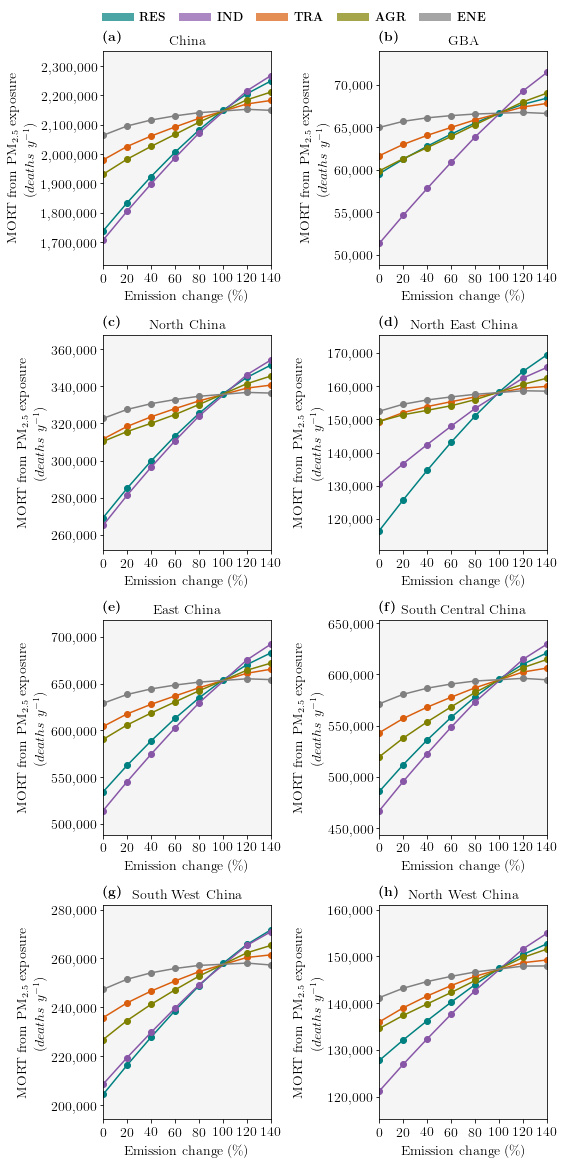

In [25]:
#for outcome in outcomes:
#    for output in outputs:
        
outcome = 'mort'
output = 'PM2_5_DRY'
        
fig = plt.figure(1, figsize=(8, 16))
gs = gridspec.GridSpec(4, 2)

for index, region in enumerate(regions_all):
    make_plot_health(index, results, region, output, outcome)


leg_1 = matplotlib.lines.Line2D([], [], color='teal', linewidth=8.0, label=r'\textbf{RES}', alpha=0.7)
leg_2 = matplotlib.lines.Line2D([], [], color='#8856a7', linewidth=8.0, label=r'\textbf{IND}', alpha=0.7)
leg_3 = matplotlib.lines.Line2D([], [], color='#d95f0e', linewidth=8.0, label=r'\textbf{TRA}', alpha=0.7)
leg_4 = matplotlib.lines.Line2D([], [], color='olive', linewidth=8.0, label=r'\textbf{AGR}', alpha=0.7)
leg_5 = matplotlib.lines.Line2D([], [], color='grey', linewidth=8.0, label=r'\textbf{ENE}', alpha=0.7)

gs.tight_layout(fig, rect=[0, 0, 1.0, 1.0])

bb = (fig.subplotpars.left + 0.06, fig.subplotpars.top + 0.03, fig.subplotpars.right - fig.subplotpars.left - 0.1, 0.1)
plt.legend(
    fontsize=12, fancybox=True, loc='upper center', bbox_to_anchor=bb, ncol=5, frameon=False,
    handles=[leg_1, leg_2, leg_3, leg_4, leg_5], mode='expand', borderaxespad=0., 
    bbox_transform=fig.transFigure
)

#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/{output}_{outcome}_line-plot_all_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/{output}_{outcome}_line-plot_all_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [34]:
popweighted_o3_6mDM8h = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_individual_inputs_region_o3_6mDM8h_scaled.joblib')
popweighted_PM2_5_DRY = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/popweighted/popweighted_individual_inputs_region_PM2_5_DRY_scaled.joblib')

In [35]:
region_keys = {
    'China': 'china',
    'GBA': 'gba',
    'North China': 'china_north',
    'North East China': 'china_north_east',
    'East China': 'china_east',
    'South Central China': 'china_south_central',
    'South West China': 'china_south_west',
    'North West China': 'china_north_west'
}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


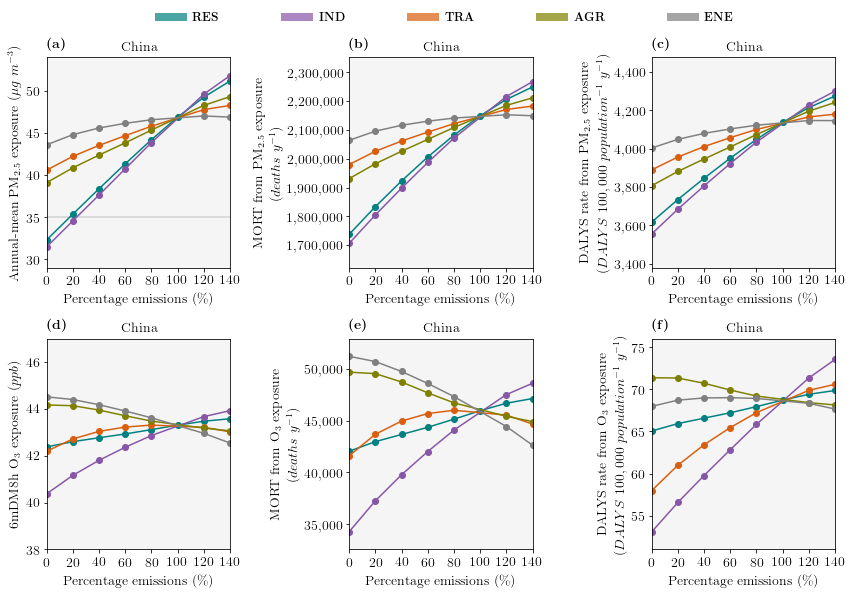

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


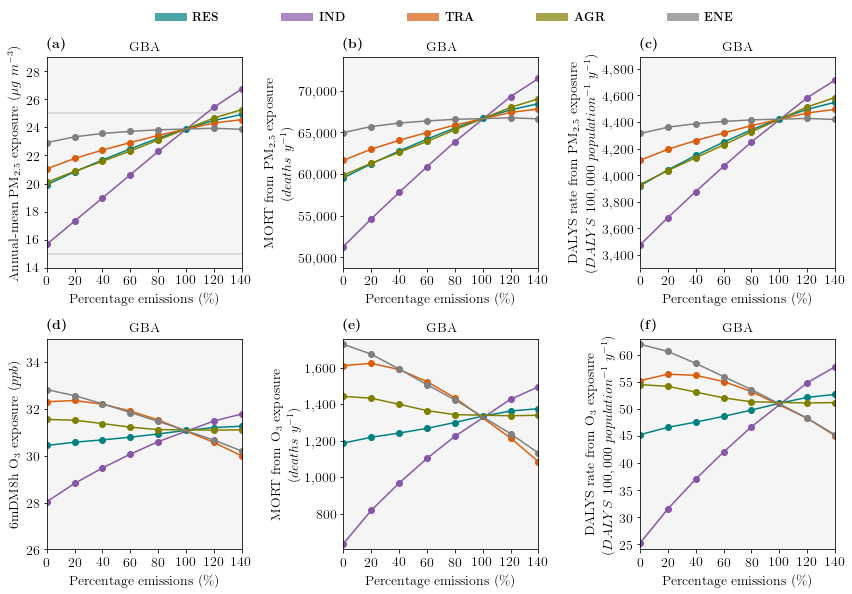

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


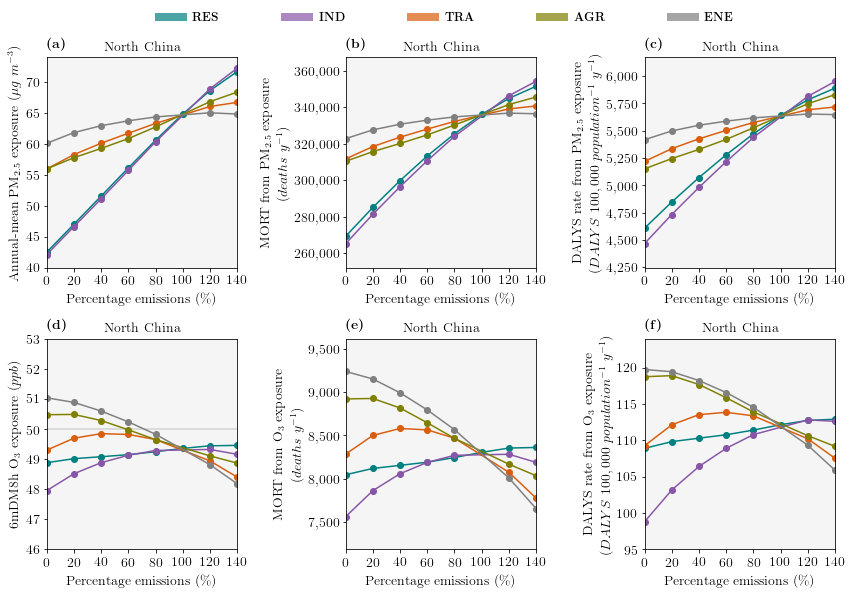

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


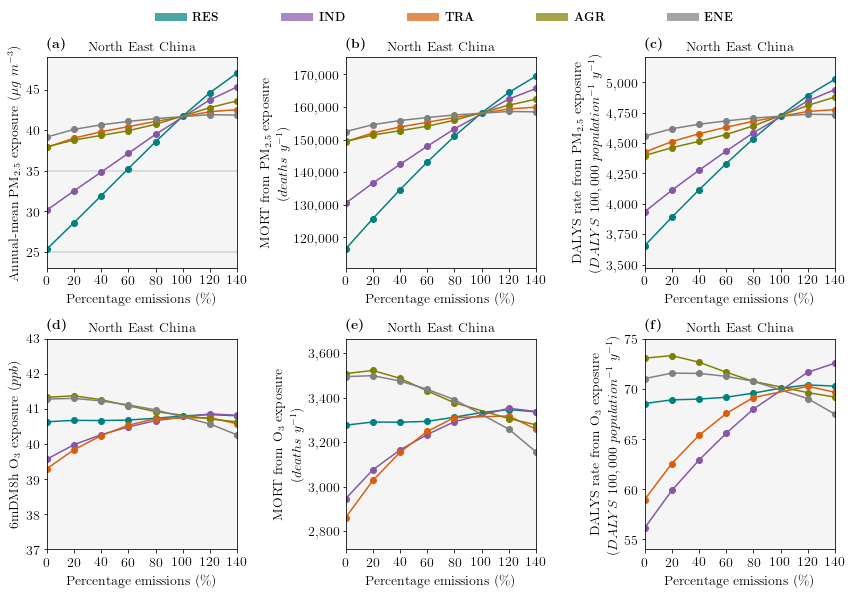

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


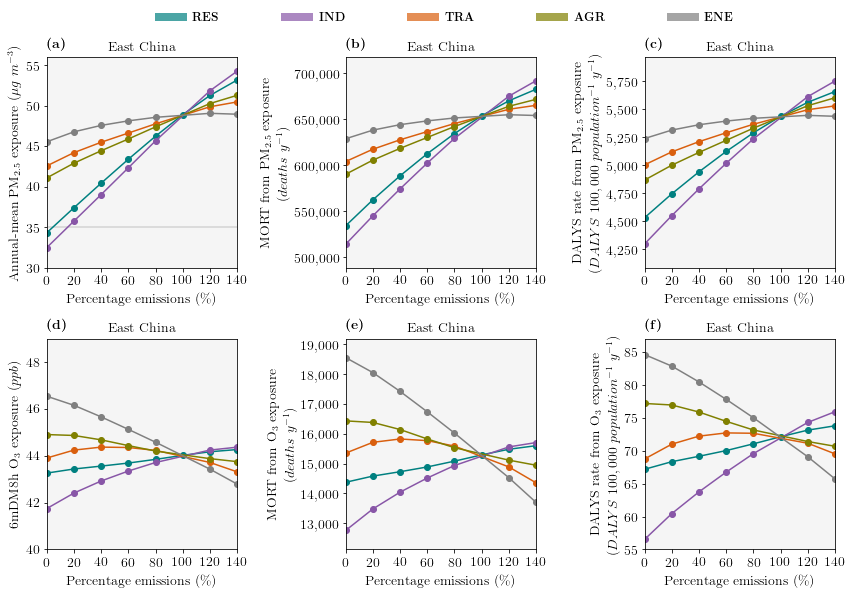

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


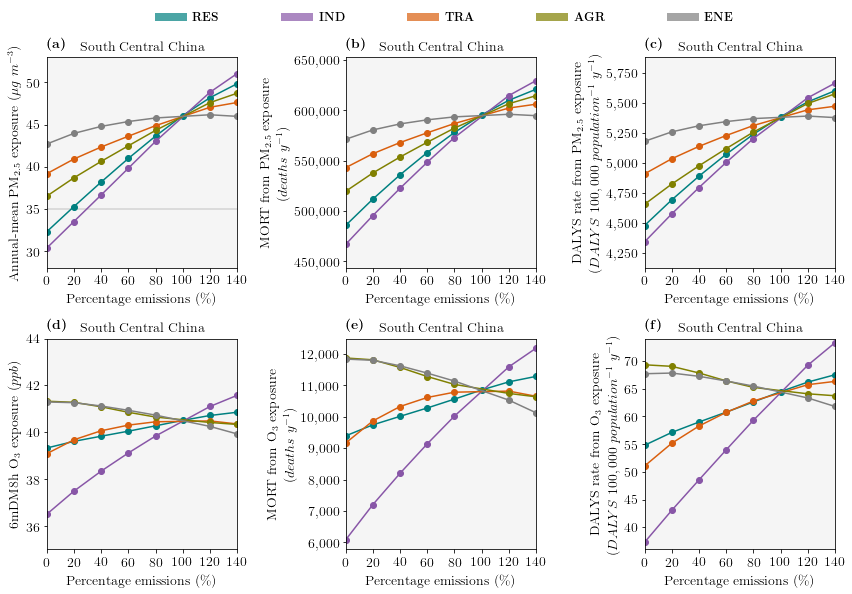

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


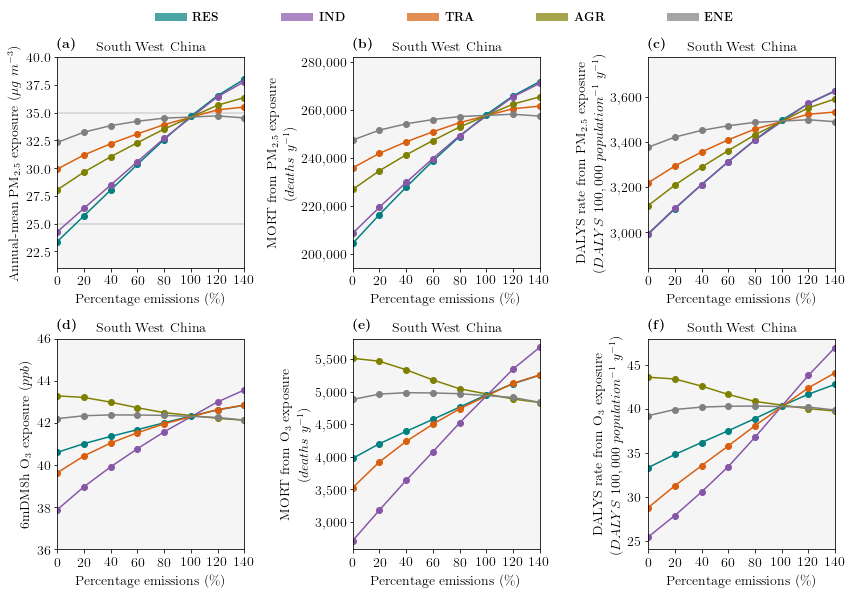

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


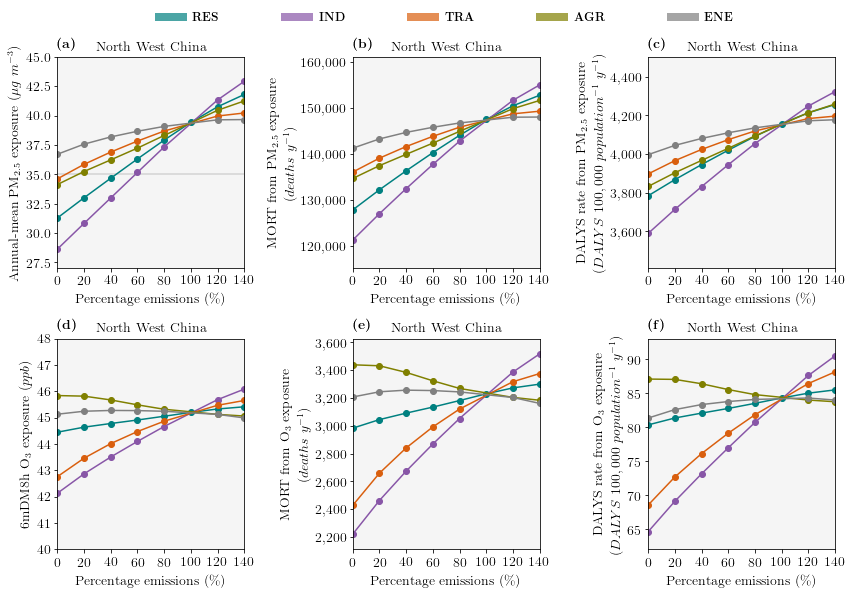

In [46]:
for region in region_keys.keys():
    fig = plt.figure(1, figsize=(12, 8))
    gs = gridspec.GridSpec(2, 3)

    make_plot_exposure(0, 'PM2_5_DRY', [item for item in popweighted_PM2_5_DRY.items() if region_keys[region] + '_PM2_5_DRY' in item[0]], 'Annual-mean PM$_{2.5}$ exposure (${\\mu}g$ $m^{-3}$)', region)
    make_plot_health(1, results, region, 'PM2_5_DRY', 'mort')
    make_plot_health(2, results, region, 'PM2_5_DRY', 'dalys_rate')
    make_plot_exposure(3, 'o3_6mDM8h', [item for item in popweighted_o3_6mDM8h.items() if region_keys[region] + '_o3_6mDM8h' in item[0]], '6mDM8h O$_{3}$ exposure ($ppb$)', region)
    make_plot_health(4, results, region, 'o3_6mDM8h', 'mort')
    make_plot_health(5, results, region, 'o3_6mDM8h', 'dalys_rate')

    leg_1 = matplotlib.lines.Line2D([], [], color='teal', linewidth=8.0, label=r'\textbf{RES}', alpha=0.7)
    leg_2 = matplotlib.lines.Line2D([], [], color='#8856a7', linewidth=8.0, label=r'\textbf{IND}', alpha=0.7)
    leg_3 = matplotlib.lines.Line2D([], [], color='#d95f0e', linewidth=8.0, label=r'\textbf{TRA}', alpha=0.7)
    leg_4 = matplotlib.lines.Line2D([], [], color='olive', linewidth=8.0, label=r'\textbf{AGR}', alpha=0.7)
    leg_5 = matplotlib.lines.Line2D([], [], color='grey', linewidth=8.0, label=r'\textbf{ENE}', alpha=0.7)

    gs.tight_layout(fig, rect=[0, 0, 1.0, 1.0])

    bb = (fig.subplotpars.left + 0.06, fig.subplotpars.top + 0.05, fig.subplotpars.right - fig.subplotpars.left - 0.1, 0.1)
    plt.legend(
        fontsize=12, fancybox=True, loc='upper center', bbox_to_anchor=bb, ncol=5, frameon=False,
        handles=[leg_1, leg_2, leg_3, leg_4, leg_5], mode='expand', borderaxespad=0., 
        bbox_transform=fig.transFigure
    )

    plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/all_line-plot_{region}_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
    plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/all_line-plot_{region}_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
    plt.show()

#### 2D contours

In [173]:
intervals = np.linspace(0, 1.4, 8)
#intervals = np.linspace(0, 1.5, 16)

matrix_stacked = np.array(
    np.meshgrid(
        intervals,
        intervals,
        intervals,
        intervals,
        intervals,
    )
).T.reshape(-1, 5)

emission_config_filenames = []

for emission_config in matrix_stacked:
    emission_config_filename = f'RES{round(emission_config[0], 1)}_IND{round(emission_config[1], 1)}_TRA{round(emission_config[2], 1)}_AGR{round(emission_config[3], 1)}_ENE{round(emission_config[4], 1)}'
    emission_config_filenames.append(emission_config_filename)

In [174]:
path_hia = f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/health_impact_assessments'

outputs = ['PM2_5_DRY', 'o3_6mDM8h']
outcomes = ['mort', 'dalys_rate']

sims_set = set(['RES', 'IND', 'TRA', 'AGR', 'ENE'])
labels_output = {
    'PM2_5_DRY': 'PM$_{2.5}$ exposure',
    'o3_6mDM8h': 'O$_3$ exposure',
}
labels = {
    'PM2_5_DRY_mort': 'MORT from PM$_{2.5}$ exposure ($deaths$ $y^{-1}$)',
    'PM2_5_DRY_dalys_rate': 'DALYS rate from PM$_{2.5}$ exposure ($DALYS$ $100,000$ $population^{-1}$ $y^{-1}$)',
    'o3_6mDM8h_mort': 'MORT from O$_3$ exposure ($deaths$ $y^{-1}$)',
    'o3_6mDM8h_dalys_rate': 'DALYS rate from O$_3$ exposure ($DALYS$ $100,000$ $population^{-1}$ $y^{-1}$)',
}
outcomes_mort = {
    'PM2_5_DRY': 'mort_ncdlri_mean_total',
    'o3_6mDM8h': 'mort_copd_mean_total',
}
outcomes_dalys_rate = {
    'PM2_5_DRY': 'dalys_rate_ncdlri_mean_total',
    'o3_6mDM8h': 'dalys_rate_copd_mean_total',
}
regions = {
    'North China': ['Beijing', 'Tianjin', 'Hebei', 'Shanxi', 'Nei Mongol'],
    'North East China': ['Liaoning', 'Jilin', 'Heilongjiang'],
    'East China': ['Shanghai', 'Jiangsu', 'Zhejiang', 'Anhui', 'Fujian', 'Jiangxi', 'Shandong'],
    'South Central China': ['Henan', 'Hubei', 'Hunan', 'Guangdong', 'Guangxi', 'Hainan'],
    'South West China': ['Chongqing', 'Sichuan', 'Guizhou', 'Yunnan', 'Xizang'],
    'North West China': ['Shaanxi', 'Gansu', 'Qinghai', 'Ningxia Hui', 'Xinjiang Uygur']
}
# GBA = Dongguan, Foshan, Guangzhou, Huizhou, Jiangmen, Shenzhen, Zhaoqing, Zhongshan, Zhuhai, Hong Kong, and Macao

regions_all = ['China', 'GBA'] + list(regions.keys())

In [175]:
results = {}

for region in regions_all:
    results.update({region: {}})
    for output in outputs:
        results[region].update({output: {}})
        for outcome in outcomes:
            results[region][output].update({outcome: {}})

In [176]:
for emission_config_filename in emission_config_filenames:
    for output in outputs:
        df_country = pd.read_csv(f'{path_hia}/{output}_scaled/df_country_hia_{output}_{emission_config_filename}_scaled.csv')
        df_province = pd.read_csv(f'{path_hia}/{output}_scaled/df_province_hia_{output}_{emission_config_filename}_scaled.csv')
        df_prefecture = pd.read_csv(f'{path_hia}/{output}_scaled/df_prefecture_hia_{output}_{emission_config_filename}_scaled.csv')

        for region in regions_all:
            for outcome in outcomes:
                if region == 'China':
                    result = df_country.loc[df_country.name == region][outcomes_keys[f'{outcome}_{output}']].values[0]
                if outcome == 'mort': # sum number of mortalities over regions
                    if region == 'GBA':
                        result = df_prefecture[outcomes_keys[f'{outcome}_{output}']].sum() + df_country.loc[df_country.name.isin(['Hong Kong', 'Macao'])][outcomes_keys[f'{outcome}_{output}']].sum()
                    if region in regions.keys():
                        result = df_province.loc[df_province.name.isin(regions[region])][outcomes_keys[f'{outcome}_{output}']].sum()
                if outcome == 'dalys_rate': # find the mean over the regions for dalys rate
                    if region == 'GBA':
                        values = np.concatenate((df_prefecture[outcomes_keys[f'{outcome}_{output}']].values, df_country.loc[df_country.name.isin(['Hong Kong', 'Macao'])][outcomes_keys[f'{outcome}_{output}']].values), axis=0)
                        values[values == 0.0] = np.nan
                        result = np.nanmean(values)
                    if region in regions.keys():
                        values = df_province.loc[df_province.name.isin(regions[region])][outcomes_keys[f'{outcome}_{output}']].values
                        values[values == 0.0] = np.nan
                        result = np.nanmean(values)
                        
                results[region][output][outcome].update({emission_config_filename: result})

In [177]:
def make_plot(index, x, y, z, region, output, outcome, sim1, sim2, levels_specific):
    ax = fig.add_subplot(gs[index])
    plt.annotate(r'\textbf{(' + chr(97 + index) + '})', xy=(0, 1.05), xycoords='axes fraction', fontsize=14)
    
    plt.xlim([0, 140])
    plt.ylim([0, 140])
    
    plt.xticks(np.arange(0, 160, 20))
    plt.yticks(np.arange(0, 160, 20))
    
    ax.set_xticklabels(np.arange(0, 160, 20))
    ax.set_yticklabels(np.arange(0, 160, 20))
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.xlabel("Percentage emissions, " + sim1 + " ({\%})", fontsize=14)
    plt.ylabel("Percentage emissions, " + sim2 + " ({\%})", fontsize=14)
    
    norm = matplotlib.colors.Normalize(vmin=levels_specific[0], vmax=levels_specific[-1])
    cmap = 'viridis'
    
    im = ax.contourf( # filled contours
        x,
        y,
        z,
        levels_specific, 
        cmap=cmap, 
        norm=norm,
        extend='both'
    )
    
    line_colors = ['black' for level in im.levels]
    cp = ax.contour( # black lines over contour gaps
        x,
        y,
        z,
        levels=levels_specific,
        colors=line_colors
    )
    comma_format = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    ax.clabel(cp, fontsize=14, colors=line_colors, fmt=comma_format, rightside_up=True) # labels for contours

In [178]:
x_labels = ['RES', 'RES', 'RES', 'RES', 'IND', 'IND', 'IND', 'TRA', 'TRA', 'AGR']
y_labels = ['IND', 'TRA', 'AGR', 'ENE', 'TRA', 'AGR', 'ENE', 'AGR', 'ENE', 'ENE']

results_x = {}
results_y = {}
results_z = {}

for outcome in outcomes:
    for output in outputs:
        for region in regions_all:             
            for index in range(len(x_labels)):
                sim1 = x_labels[index]
                sim2 = y_labels[index]

                sims_to_hold = list(sims_set - set([sim1, sim2]))

                x = []
                y = []
                z = []

                for key, value in results[region][output][outcome].items():
                    if f'{sims_to_hold[0]}1.0' in key and f'{sims_to_hold[1]}1.0' in key and f'{sims_to_hold[2]}1.0' in key:
                        x.append(float(re.findall(r'' + sim1 + '\d+\.\d+', key)[0].split(sim1)[1]) * 100)
                        y.append(float(re.findall(r'' + sim2 + '\d+\.\d+', key)[0].split(sim2)[1]) * 100)
                        z.append(value)

                x = np.array(x).reshape(len(intervals), len(intervals))
                y = np.array(y).reshape(len(intervals), len(intervals))
                z = np.array(z).reshape(len(intervals), len(intervals))

                results_x.update({f'{region}_{output}_{outcome}_{sim1}_{sim2}': x})
                results_y.update({f'{region}_{output}_{outcome}_{sim1}_{sim2}': y})
                results_z.update({f'{region}_{output}_{outcome}_{sim1}_{sim2}': z})

In [186]:
levels = {}
for outcome in outcomes:
    for output in outputs:
        for region in regions_all:
            if output == 'PM2_5_DRY':
                z_min = results_z[f'{region}_{output}_{outcome}_RES_IND']
                z_max = results_z[f'{region}_{output}_{outcome}_RES_IND']
            if output == 'o3_6mDM8h':
                z_min = results_z[f'{region}_{output}_{outcome}_IND_TRA']
                z_max = results_z[f'{region}_{output}_{outcome}_AGR_ENE']
            
            if outcome == 'mort':
                min_level = round(np.nanmin(z_min), -3) - 1_000
                max_level = round(np.nanmax(z_max), -3) + 1_000
            elif outcome == 'dalys_rate' and output == 'PM2_5_DRY':
                min_level = round(np.nanmin(z_min), -2) - 20
                max_level = round(np.nanmax(z_max), -2) + 20
            elif outcome == 'dalys_rate' and output == 'o3_6mDM8h':
                min_level = round(np.nanmin(z_min), -1) - 2
                max_level = round(np.nanmax(z_max), -1) + 2
            levels_specific = np.linspace(min_level, max_level, 11)
            
            levels.update({f'{region}_{output}_{outcome}': levels_specific})

<ipython-input-204-e74f867d5c93>:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig, rect=[0, 0, 0.9, 0.9])


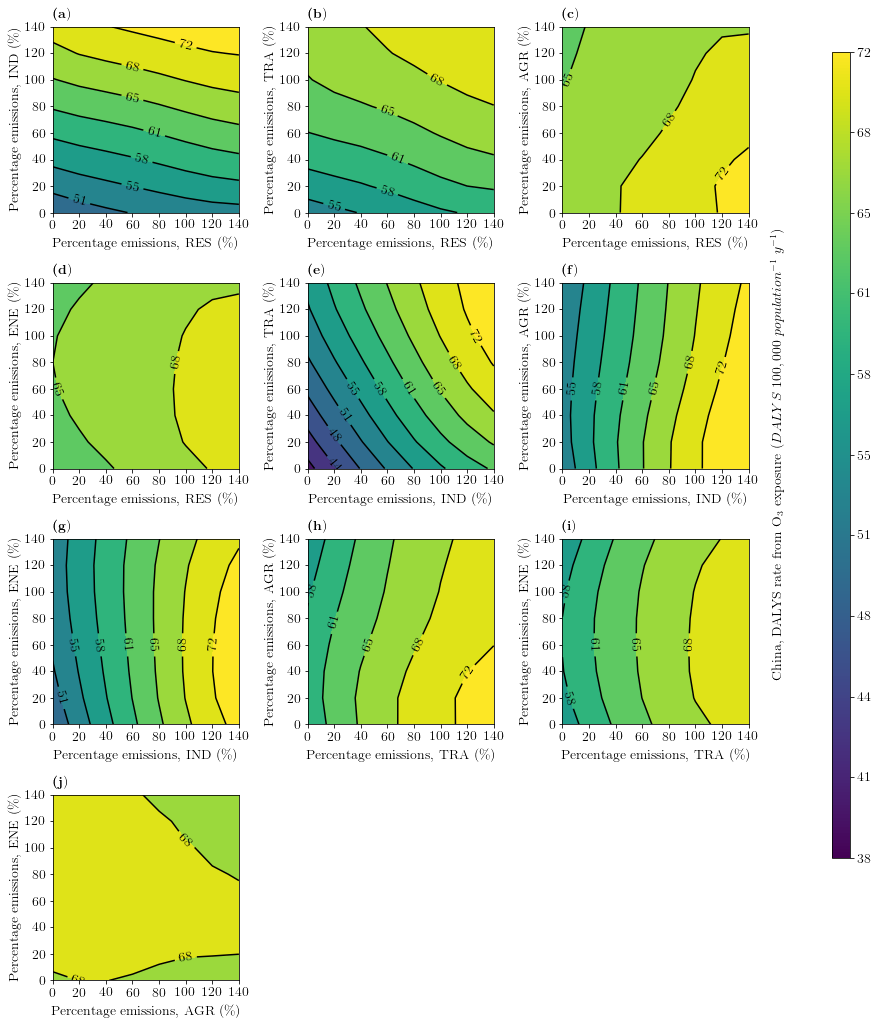

In [204]:
# outcome in outcomes:
#    for output in outputs:
#        for region in regions_all:   
outcome = 'dalys_rate'
output = 'o3_6mDM8h'
region = 'China'

levels_specific = levels[f'{region}_{output}_{outcome}']

fig = plt.figure(1, figsize=(12, 16))
gs = gridspec.GridSpec(4, 3)

for index in range(len(x_labels)):
    make_plot(
        index,
        results_x[f'{region}_{output}_{outcome}_{x_labels[index]}_{y_labels[index]}'], 
        results_y[f'{region}_{output}_{outcome}_{x_labels[index]}_{y_labels[index]}'],
        results_z[f'{region}_{output}_{outcome}_{x_labels[index]}_{y_labels[index]}'],
        region, 
        output, 
        outcome, 
        x_labels[index], 
        y_labels[index],
        levels_specific
    )

ax_cbar = fig.add_axes([0.97, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=levels_specific[0], vmax=levels_specific[-1]),
    cmap='viridis'
)
sm.set_array([])  
cb = plt.colorbar(
    sm, 
    cax=ax_cbar, 
    norm=matplotlib.colors.Normalize(vmin=levels_specific[0], vmax=levels_specific[-1]),              
    cmap='viridis', 
    ticks=levels_specific
)
ticks = [str(format(int(item), ',')) for item in levels_specific]
cb.ax.set_yticklabels(ticks)
cb.set_label(f'{region}, {labels[f"{output}_{outcome}"]}', size=14, labelpad=-100)
cb.ax.tick_params(labelsize=14)

gs.tight_layout(fig, rect=[0, 0, 0.9, 0.9])
plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/{output}_{outcome}_{region}_2d-popweight-contour_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/{output}_{outcome}_{region}_2d-popweight-contour_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [8]:
regions_all_and_others = regions_all + list(set(df_country.name.unique()) - set(['China'])) + list(df_province.name.unique()) + list(df_prefecture.name.unique())

In [9]:
results_compare = {}
outcomes_keys_compare = {
    'exposure_PM2_5_DRY_mean': 'pm25_popweighted',
    'exposure_o3_6mDM8h_mean': 'o3_popweighted',
    'mort_PM2_5_DRY_mean': 'mort_ncdlri_mean_total',
    'mort_o3_6mDM8h_mean': 'mort_copd_mean_total',
    'mort_PM2_5_DRY_lower': 'mort_ncdlri_lower_total',
    'mort_o3_6mDM8h_lower': 'mort_copd_lower_total',
    'mort_PM2_5_DRY_upper': 'mort_ncdlri_upper_total',
    'mort_o3_6mDM8h_upper': 'mort_copd_upper_total',
    'dalys_rate_PM2_5_DRY_mean': 'dalys_rate_ncdlri_mean_total',
    'dalys_rate_o3_6mDM8h_mean': 'dalys_rate_copd_mean_total',
    'dalys_rate_PM2_5_DRY_lower': 'dalys_rate_ncdlri_lower_total',
    'dalys_rate_o3_6mDM8h_lower': 'dalys_rate_copd_lower_total',
    'dalys_rate_PM2_5_DRY_upper': 'dalys_rate_ncdlri_upper_total',
    'dalys_rate_o3_6mDM8h_upper': 'dalys_rate_copd_upper_total',
}

for region in regions_all_and_others:
    results_compare.update({region: {}})
    for output in outputs:
        results_compare[region].update({output: {}})
        for outcome in ['exposure', 'mort', 'dalys_rate']:
            results_compare[region][output].update({outcome: {}})
            for metric in ['mean', 'lower', 'upper']:
                if outcome == 'exposure' and metric != 'mean':
                    continue
                else:
                    results_compare[region][output][outcome].update({metric: {}})

In [10]:
for emission_config_filename in emission_config_filenames:
    for output in ['PM2_5_DRY', 'o3_6mDM8h']:
        df_country = pd.read_csv(f'{path_hia}/{output}_scaled/df_country_hia_{output}_{emission_config_filename}_scaled.csv')
        df_province = pd.read_csv(f'{path_hia}/{output}_scaled/df_province_hia_{output}_{emission_config_filename}_scaled.csv')
        df_prefecture = pd.read_csv(f'{path_hia}/{output}_scaled/df_prefecture_hia_{output}_{emission_config_filename}_scaled.csv')

        for outcome in ['exposure', 'mort', 'dalys_rate']:
            for metric in ['mean', 'lower', 'upper']:
                if outcome == 'exposure' and metric != 'mean':
                    continue
                else:
                    for region in df_country.name.unique():
                        result = df_country.loc[df_country.name == region][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values[0]
                        results_compare[region][output][outcome][metric].update({emission_config_filename: result})
                    
                    for region in df_province.name.unique():
                        result = df_province.loc[df_province.name == region][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values[0]
                        results_compare[region][output][outcome][metric].update({emission_config_filename: result})
                    
                    for region in df_prefecture.name.unique():
                        result = df_prefecture.loc[df_prefecture.name == region][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values[0]
                        results_compare[region][output][outcome][metric].update({emission_config_filename: result})
                    
                    for region in regions_all:
                        if region == 'China':
                            result = df_country.loc[df_country.name == region][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values[0]
                        if outcome == 'mort': # sum number of mortalities over regions
                            if region == 'GBA':
                                result = df_prefecture[outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum() + df_country.loc[df_country.name.isin(['Hong Kong', 'Macao'])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum()
                            if region in regions.keys():
                                result = df_province.loc[df_province.name.isin(regions[region])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum()
                        if outcome == 'dalys_rate' or outcome  == 'exposure': # find the mean over the regions for dalys rate and exposure
                            if region == 'GBA':
                                values = np.concatenate((df_prefecture[outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values, df_country.loc[df_country.name.isin(['Hong Kong', 'Macao'])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values), axis=0)
                                values[values == 0.0] = np.nan
                                result = np.nanmean(values)
                            if region in regions.keys():
                                values = df_province.loc[df_province.name.isin(regions[region])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values
                                values[values == 0.0] = np.nan
                                result = np.nanmean(values)


                        results_compare[region][output][outcome][metric].update({emission_config_filename: result})

In [11]:
joblib.dump(results_compare, '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/health_impact_assessments/results_compare_scaled.joblib.compressed', compress=True)

['/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/health_impact_assessments/results_compare_scaled.joblib.compressed']

In [12]:
results_compare_china = results_compare['China']
joblib.dump(results_compare_china, '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/health_impact_assessments/results_compare_china_scaled.joblib.compressed', compress=True)

['/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/health_impact_assessments/results_compare_china_scaled.joblib.compressed']

In [207]:
results_compare = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/health_impact_assessments/results_compare_scaled.joblib.compressed')

In [237]:
for output in ['o3_6mDM8h']: # ['PM2_5_DRY', 'o3_6mDM8h']:
    print(output)
    for outcome in ['mort', 'dalys_rate']: # ['mort', 'dalys_rate']
        print(outcome)
        for region in regions_all[0:1]: # [0:1] for China, [1:] for without China
            print(region)
            ctl_mean = results_compare[region][output][outcome]['mean']['RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
            ctl_lower = results_compare[region][output][outcome]['lower']['RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
            ctl_upper = results_compare[region][output][outcome]['upper']['RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
            no_res_mean = results_compare[region][output][outcome]['mean']['RES0.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
            no_res_lower = results_compare[region][output][outcome]['lower']['RES0.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
            no_res_upper = results_compare[region][output][outcome]['upper']['RES0.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
            no_ind_mean = results_compare[region][output][outcome]['mean']['RES1.0_IND0.0_TRA1.0_AGR1.0_ENE1.0']
            no_ind_lower = results_compare[region][output][outcome]['lower']['RES1.0_IND0.0_TRA1.0_AGR1.0_ENE1.0']
            no_ind_upper = results_compare[region][output][outcome]['upper']['RES1.0_IND0.0_TRA1.0_AGR1.0_ENE1.0']
            no_tra_mean = results_compare[region][output][outcome]['mean']['RES1.0_IND1.0_TRA0.0_AGR1.0_ENE1.0']
            no_tra_lower = results_compare[region][output][outcome]['lower']['RES1.0_IND1.0_TRA0.0_AGR1.0_ENE1.0']
            no_tra_upper = results_compare[region][output][outcome]['upper']['RES1.0_IND1.0_TRA0.0_AGR1.0_ENE1.0']
            no_agr_mean = results_compare[region][output][outcome]['mean']['RES1.0_IND1.0_TRA1.0_AGR0.0_ENE1.0']
            no_agr_lower = results_compare[region][output][outcome]['lower']['RES1.0_IND1.0_TRA1.0_AGR0.0_ENE1.0']
            no_agr_upper = results_compare[region][output][outcome]['upper']['RES1.0_IND1.0_TRA1.0_AGR0.0_ENE1.0']
            no_ene_mean = results_compare[region][output][outcome]['mean']['RES1.0_IND1.0_TRA1.0_AGR1.0_ENE0.0']
            no_ene_lower = results_compare[region][output][outcome]['lower']['RES1.0_IND1.0_TRA1.0_AGR1.0_ENE0.0']
            no_ene_upper = results_compare[region][output][outcome]['upper']['RES1.0_IND1.0_TRA1.0_AGR1.0_ENE0.0']
            no_res_ind_mean = results_compare[region][output][outcome]['mean']['RES0.0_IND0.0_TRA1.0_AGR1.0_ENE1.0']
            no_res_ind_lower = results_compare[region][output][outcome]['lower']['RES0.0_IND0.0_TRA1.0_AGR1.0_ENE1.0']
            no_res_ind_upper = results_compare[region][output][outcome]['upper']['RES0.0_IND0.0_TRA1.0_AGR1.0_ENE1.0']
            no_tra_ind_mean = results_compare[region][output][outcome]['mean']['RES1.0_IND0.0_TRA0.0_AGR1.0_ENE1.0']
            no_tra_ind_lower = results_compare[region][output][outcome]['lower']['RES1.0_IND0.0_TRA0.0_AGR1.0_ENE1.0']
            no_tra_ind_upper = results_compare[region][output][outcome]['upper']['RES1.0_IND0.0_TRA0.0_AGR1.0_ENE1.0']
            no_tra_ene_mean = results_compare[region][output][outcome]['mean']['RES1.0_IND1.0_TRA0.0_AGR1.0_ENE0.0']
            no_tra_ene_lower = results_compare[region][output][outcome]['lower']['RES1.0_IND1.0_TRA0.0_AGR1.0_ENE0.0']
            no_tra_ene_upper = results_compare[region][output][outcome]['upper']['RES1.0_IND1.0_TRA0.0_AGR1.0_ENE0.0']
            no_agr_ene_mean = results_compare[region][output][outcome]['mean']['RES1.0_IND1.0_TRA1.0_AGR0.0_ENE0.0']
            no_agr_ene_lower = results_compare[region][output][outcome]['lower']['RES1.0_IND1.0_TRA1.0_AGR0.0_ENE0.0']
            no_agr_ene_upper = results_compare[region][output][outcome]['upper']['RES1.0_IND1.0_TRA1.0_AGR0.0_ENE0.0']
            no_agr_tra_mean = results_compare[region][output][outcome]['mean']['RES1.0_IND1.0_TRA0.0_AGR0.0_ENE1.0']
            no_agr_tra_lower = results_compare[region][output][outcome]['lower']['RES1.0_IND1.0_TRA0.0_AGR0.0_ENE1.0']
            no_agr_tra_upper = results_compare[region][output][outcome]['upper']['RES1.0_IND1.0_TRA0.0_AGR0.0_ENE1.0']
            no_tra_agr_ene_mean = results_compare[region][output][outcome]['mean']['RES1.0_IND1.0_TRA0.0_AGR0.0_ENE0.0']
            no_tra_agr_ene_lower = results_compare[region][output][outcome]['lower']['RES1.0_IND1.0_TRA0.0_AGR0.0_ENE0.0']
            no_tra_agr_ene_upper = results_compare[region][output][outcome]['upper']['RES1.0_IND1.0_TRA0.0_AGR0.0_ENE0.0']

            min_emission_configs = {}
            min_values_mean = {}
            min_values_lower = {}
            min_values_upper = {}
            current_min = float('inf')
            for emission_config, value in results_compare[region][output][outcome]['mean'].items():
                if value < current_min:
                    min_emission_configs.update({f'{region}_{output}_{outcome}': emission_config})
                    min_values_mean.update({f'{region}_{output}_{outcome}': value})
                    min_values_lower.update({f'{region}_{output}_{outcome}': results_compare[region][output][outcome]['lower'][emission_config]})
                    min_values_upper.update({f'{region}_{output}_{outcome}': results_compare[region][output][outcome]['upper'][emission_config]})
                    current_min = value

            if outcome == 'mort':
                round_to = -2
            if outcome == 'dalys_rate':
                round_to = 1
            #print(f"ctl, {outcome} = {int(round(ctl_mean, round_to)):,} (95UI: {int(round(ctl_lower, round_to)):,} to {int(round(ctl_upper, round_to)):,})")
            #print(f"min for {min_emission_configs[f'{region}_{output}_{outcome}']}, {outcome} reduction of = {int(round(min_values_mean[f'{region}_{output}_{outcome}'] - ctl_mean, round_to)):,} ({int(round(min_values_lower[f'{region}_{output}_{outcome}'] - ctl_lower, round_to)):,} to {int(round(min_values_upper[f'{region}_{output}_{outcome}'] - ctl_upper, round_to)):,}), {int(round(100 * ((min_values_mean[f'{region}_{output}_{outcome}'] / ctl_mean) - 1), 0))}%")
            #print(f"no res, {outcome} reduction of = {int(round(no_res_mean - ctl_mean, round_to)):,} ({int(round(no_res_lower - ctl_lower, round_to)):,} to {int(round(no_res_upper - ctl_upper, round_to)):,}), {int(round(100 * ((no_res_mean / ctl_mean) - 1), 0))}%")
            #print(f"no ind, {outcome} reduction of = {int(round(no_ind_mean - ctl_mean, round_to)):,} ({int(round(no_ind_lower - ctl_lower, round_to)):,} to {int(round(no_ind_upper - ctl_upper, round_to)):,}), {int(round(100 * ((no_ind_mean / ctl_mean) - 1), 0))}%")
            #print(f"no tra, {outcome} reduction of = {int(round(no_tra_mean - ctl_mean, round_to)):,} ({int(round(no_tra_lower - ctl_lower, round_to)):,} to {int(round(no_tra_upper - ctl_upper, round_to)):,}), {int(round(100 * ((no_tra_mean / ctl_mean) - 1), 0))}%")
            #print(f"no agr, {outcome} reduction of = {int(round(no_agr_mean - ctl_mean, round_to)):,} ({int(round(no_agr_lower - ctl_lower, round_to)):,} to {int(round(no_agr_upper - ctl_upper, round_to)):,}), {int(round(100 * ((no_agr_mean / ctl_mean) - 1), 0))}%")
            #print(f"no ene, {outcome} reduction of = {int(round(no_ene_mean - ctl_mean, round_to)):,} ({int(round(no_ene_lower - ctl_lower, round_to)):,} to {int(round(no_ene_upper - ctl_upper, round_to)):,}), {int(round(100 * ((no_ene_mean / ctl_mean) - 1), 0))}%")
            #print(f"no res ind, {outcome} reduction of = {int(round(no_res_ind_mean - ctl_mean, round_to)):,} ({int(round(no_res_ind_lower - ctl_lower, round_to)):,} to {int(round(no_res_ind_upper - ctl_upper, round_to)):,}), {int(round(100 * ((no_res_ind_mean / ctl_mean) - 1), 0))}%")
            #print(f"no tra ind, {outcome} reduction of = {int(round(no_tra_ind_mean - ctl_mean, round_to)):,} ({int(round(no_tra_ind_lower - ctl_lower, round_to)):,} to {int(round(no_tra_ind_upper - ctl_upper, round_to)):,}), {int(round(100 * ((no_tra_ind_mean / ctl_mean) - 1), 0))}%")
            print(f"no tra ene, {outcome} reduction of = {int(round(no_tra_ene_mean - ctl_mean, round_to)):,} ({int(round(no_tra_ene_lower - ctl_lower, round_to)):,} to {int(round(no_tra_ene_upper - ctl_upper, round_to)):,}), {int(round(100 * ((no_tra_ene_mean / ctl_mean) - 1), 0))}%")
            print(f"no agr ene, {outcome} reduction of = {int(round(no_agr_ene_mean - ctl_mean, round_to)):,} ({int(round(no_agr_ene_lower - ctl_lower, round_to)):,} to {int(round(no_agr_ene_upper - ctl_upper, round_to)):,}), {int(round(100 * ((no_agr_ene_mean / ctl_mean) - 1), 0))}%")
            print(f"no agr tra, {outcome} reduction of = {int(round(no_agr_tra_mean - ctl_mean, round_to)):,} ({int(round(no_agr_tra_lower - ctl_lower, round_to)):,} to {int(round(no_agr_tra_upper - ctl_upper, round_to)):,}), {int(round(100 * ((no_agr_tra_mean / ctl_mean) - 1), 0))}%")
            #print(f"no tra agr ene, {outcome} reduction of = {int(round(no_tra_agr_ene_mean - ctl_mean, round_to)):,} ({int(round(no_tra_agr_ene_lower - ctl_lower, round_to)):,} to {int(round(no_tra_agr_ene_upper - ctl_upper, round_to)):,}), {int(round(100 * ((no_tra_agr_ene_mean / ctl_mean) - 1), 0))}%")
            print()

o3_6mDM8h
mort
China
no tra ene, mort reduction of = -200 (-100 to -400), 0%
no agr ene, mort reduction of = 6,100 (4,300 to 8,500), 13%
no agr tra, mort reduction of = -2,100 (-1,400 to -3,000), -5%

dalys_rate
China
no tra ene, dalys_rate reduction of = -12 (-8 to -17), -18%
no agr ene, dalys_rate reduction of = 0 (0 to -1), -1%
no agr tra, dalys_rate reduction of = -9 (-6 to -13), -14%



In [244]:
round_to = -2

In [245]:
ctl_mean_total = results_compare['China']['PM2_5_DRY']['mort']['mean']['RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0'] + results_compare['China']['o3_6mDM8h']['mort']['mean']['RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
ctl_lower_total = results_compare['China']['PM2_5_DRY']['mort']['lower']['RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0'] + results_compare['China']['o3_6mDM8h']['mort']['lower']['RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
ctl_upper_total = results_compare['China']['PM2_5_DRY']['mort']['upper']['RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0'] + results_compare['China']['o3_6mDM8h']['mort']['upper']['RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0']
print(f"ctl total, mort = {int(round(ctl_mean_total, round_to)):,} (95UI: {int(round(ctl_lower_total, round_to)):,} to {int(round(ctl_upper_total, round_to)):,})")

ctl total, mort = 2,194,900 (95UI: 2,120,400 to 2,280,500)


In [250]:
no_res_ind_mean_total = results_compare['China']['PM2_5_DRY']['mort']['mean']['RES0.0_IND0.0_TRA1.0_AGR1.0_ENE1.0'] + results_compare['China']['o3_6mDM8h']['mort']['mean']['RES0.0_IND0.0_TRA1.0_AGR1.0_ENE1.0']
no_res_ind_lower_total = results_compare['China']['PM2_5_DRY']['mort']['lower']['RES0.0_IND0.0_TRA1.0_AGR1.0_ENE1.0'] + results_compare['China']['o3_6mDM8h']['mort']['lower']['RES0.0_IND0.0_TRA1.0_AGR1.0_ENE1.0']
no_res_ind_upper_total = results_compare['China']['PM2_5_DRY']['mort']['upper']['RES0.0_IND0.0_TRA1.0_AGR1.0_ENE1.0'] + results_compare['China']['o3_6mDM8h']['mort']['upper']['RES0.0_IND0.0_TRA1.0_AGR1.0_ENE1.0']
#print(f"no res ind total, mort = {int(round(no_res_ind_mean_total, round_to)):,} (95UI: {int(round(no_res_ind_lower_total, round_to)):,} to {int(round(no_res_ind_upper_total, round_to)):,})")
print(f"no res ind total, mort reduction of = {int(round(no_res_ind_mean_total - ctl_mean_total, round_to)):,} ({int(round(no_res_ind_lower_total - ctl_lower_total, round_to)):,} to {int(round(no_res_ind_upper_total - ctl_upper_total, round_to)):,}), {int(round(100 * ((no_res_ind_mean_total / ctl_mean_total) - 1), 0))}%")

no res ind total, mort reduction of = -919,400 (-889,000 to -954,200), -42%


In [252]:
min_mean_total = results_compare['China']['PM2_5_DRY']['mort']['mean']['RES0.0_IND0.0_TRA0.0_AGR0.0_ENE0.0'] + results_compare['China']['o3_6mDM8h']['mort']['mean']['RES0.0_IND0.0_TRA0.0_AGR0.0_ENE0.0']
min_lower_total = results_compare['China']['PM2_5_DRY']['mort']['lower']['RES0.0_IND0.0_TRA0.0_AGR0.0_ENE0.0'] + results_compare['China']['o3_6mDM8h']['mort']['lower']['RES0.0_IND0.0_TRA0.0_AGR0.0_ENE0.0']
min_upper_total = results_compare['China']['PM2_5_DRY']['mort']['upper']['RES0.0_IND0.0_TRA0.0_AGR0.0_ENE0.0'] + results_compare['China']['o3_6mDM8h']['mort']['upper']['RES0.0_IND0.0_TRA0.0_AGR0.0_ENE0.0']
#print(f"min total, mort = {int(round(min_mean_total, round_to)):,} (95UI: {int(round(min_lower_total, round_to)):,} to {int(round(min_upper_total, round_to)):,})")
print(f"min total, mort reduction of = {int(round(min_mean_total - ctl_mean_total, round_to)):,} ({int(round(min_lower_total - ctl_lower_total, round_to)):,} to {int(round(min_upper_total - ctl_upper_total, round_to)):,}), {int(round(100 * ((min_mean_total / ctl_mean_total) - 1), 0))}%")

min total, mort reduction of = -1,241,800 (-1,199,300 to -1,290,600), -57%


In [233]:
for region_output, values in predictions.items():
    #if region_output == 'china_o3':# or region_output == 'china_o3':
    if 'o3' in region_output:
        filenames = [item[0] for item in values if item != None if item[1] != 0.0]
        outputs = [item[1] for item in values if item != None if item[1] != 0.0]
        min_index = outputs.index(min(outputs))
        ctl = [item[1] for item in values if 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0' in item[0]][0]
        no_res = [item[1] for item in values if 'RES0.0_IND1.0_TRA1.0_AGR1.0_ENE1.0' in item[0]][0]
        no_ind = [item[1] for item in values if 'RES1.0_IND0.0_TRA1.0_AGR1.0_ENE1.0' in item[0]][0]
        no_tra = [item[1] for item in values if 'RES1.0_IND1.0_TRA0.0_AGR1.0_ENE1.0' in item[0]][0]
        no_agr = [item[1] for item in values if 'RES1.0_IND1.0_TRA1.0_AGR0.0_ENE1.0' in item[0]][0]
        no_ene = [item[1] for item in values if 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE0.0' in item[0]][0]
        no_res_ind = [item[1] for item in values if 'RES0.0_IND0.0_TRA1.0_AGR1.0_ENE1.0' in item[0]][0]
        no_tra_ind = [item[1] for item in values if 'RES1.0_IND0.0_TRA0.0_AGR1.0_ENE1.0' in item[0]][0]
        no_tra_ene = [item[1] for item in values if 'RES1.0_IND1.0_TRA0.0_AGR1.0_ENE0.0' in item[0]][0]
        no_agr_ene = [item[1] for item in values if 'RES1.0_IND1.0_TRA1.0_AGR0.0_ENE0.0' in item[0]][0]
        no_agr_tra = [item[1] for item in values if 'RES1.0_IND1.0_TRA0.0_AGR0.0_ENE1.0' in item[0]][0]
        no_tra_agr_ene = [item[1] for item in values if 'RES1.0_IND1.0_TRA0.0_AGR0.0_ENE0.0' in item[0]][0]
        print(region_output)
        print(f'min for {filenames[min_index][3:37]}, exposure = {round(outputs[min_index], 1)}, {int(round(100 * ((outputs[min_index] / ctl) - 1), 0))}%')
        #print(f'no res, exposure = {round(no_res, 1)}, {int(round(100 * ((no_res / ctl) - 1), 0))}%')
        #print(f'no ind, exposure = {round(no_ind, 1)}, {int(round(100 * ((no_ind / ctl) - 1), 0))}%')
        #print(f'no tra, exposure = {round(no_tra, 1)}, {int(round(100 * ((no_tra / ctl) - 1), 0))}%')
        #print(f'no agr, exposure = {round(no_agr, 1)}, {int(round(100 * ((no_agr / ctl) - 1), 0))}%')
        #print(f'no ene, exposure = {round(no_ene, 1)}, {int(round(100 * ((no_ene / ctl) - 1), 0))}%')
        #print(f'no res_ind, exposure = {round(no_res_ind, 1)}, {int(round(100 * ((no_res_ind / ctl) - 1), 0))}%')
        #print(f'no tra_ind, exposure = {round(no_tra_ind, 1)}, {int(round(100 * ((no_tra_ind / ctl) - 1), 0))}%')
        #print(f'no tra_ene, exposure = {round(no_tra_ene, 1)}, {int(round(100 * ((no_tra_ene / ctl) - 1), 0))}%')
        #print(f'no agr_ene, exposure = {round(no_agr_ene, 1)}, {int(round(100 * ((no_agr_ene / ctl) - 1), 0))}%')
        #print(f'no agr_tra, exposure = {round(no_agr_tra, 1)}, {int(round(100 * ((no_agr_tra / ctl) - 1), 0))}%')
        #print(f'no tra_agr_ene, exposure = {round(no_tra_agr_ene, 1)}, {int(round(100 * ((no_tra_agr_ene / ctl) - 1), 0))}%')
        print()

china_o3
min for RES0.0_IND0.0_TRA0.0_AGR1.4_ENE1.4, exposure = 34.7, -20%

gba_o3
min for RES0.0_IND0.0_TRA0.0_AGR0.0_ENE1.4, exposure = 25.1, -19%

china_north_o3
min for RES0.0_IND0.0_TRA0.0_AGR1.4_ENE1.4, exposure = 42.5, -14%

china_north_east_o3
min for RES0.0_IND0.0_TRA0.0_AGR0.0_ENE0.0, exposure = 35.1, -14%

china_east_o3
min for RES0.0_IND0.0_TRA0.0_AGR1.4_ENE1.4, exposure = 36.5, -17%

china_south_central_o3
min for RES0.0_IND0.0_TRA0.0_AGR0.0_ENE0.0, exposure = 30.2, -25%

china_south_west_o3
min for RES0.0_IND0.0_TRA0.0_AGR0.0_ENE0.0, exposure = 29.4, -30%

china_north_west_o3
min for RES0.0_IND0.0_TRA0.0_AGR0.0_ENE0.0, exposure = 35.6, -21%



### convert data for bokeh plot

In [13]:
def geodataframe_to_columndatasource_df(
    gdf, 
    polygon_name_column='NAME_1',
    scenario_variable='RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0'):
    xs = []
    ys = []
    for obj in gdf.geometry.boundary:
        if obj.type == 'LineString':
            obj_x, obj_y = obj.xy
            xs.append([[list(obj_x)]])
            ys.append([[list(obj_y)]])
        elif obj.type == 'MultiLineString':
            obj_x = []
            obj_y = []
            for line in obj:
                line_x, line_y = line.xy
                obj_x.append([list(line_x)])
                obj_y.append([list(line_y)])
            xs.append(obj_x)
            ys.append(obj_y)

    locations = gdf[polygon_name_column].values
    df = pd.DataFrame({
        'location': locations,
        'xs': xs, 
        'ys': ys, 
        'scenario_variable': gdf[scenario_variable]})
    for col in [col for col in gdf.columns if 'RES' in col]:
        df[col] = gdf[col]
    return df

In [26]:
# source per outcome
source_dfs = {}
options = []

sims = list(results_compare['China'][output][outcome][metric].keys())

for outcome in ['exposure', 'mort', 'dalys_rate']:
    for metric in ['mean', 'lower', 'upper']:
        if outcome == 'exposure' and metric != 'mean':
            continue
        else:
            for output in outputs:
                gdf = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_1.shp')

                for region in gdf.NAME_1.unique():
                    for sim in sims:
                        options.append(f'{sim}')
                        result = results_compare[region][output][outcome][metric][sim]
                        gdf.loc[gdf.NAME_1 == region, f'{sim}'] = result

                source_df = geodataframe_to_columndatasource_df(
                    gdf, 
                    polygon_name_column='NAME_1', 
                    scenario_variable='RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0')
                source_dfs.update({f'{output}_{outcome}_{metric}': source_df})
    
options = sorted(list(set(options)))

In [30]:
source_dfs.keys()

dict_keys(['PM2_5_DRY_exposure_mean', 'o3_6mDM8h_exposure_mean', 'PM2_5_DRY_mort_mean', 'o3_6mDM8h_mort_mean', 'PM2_5_DRY_mort_lower', 'o3_6mDM8h_mort_lower', 'PM2_5_DRY_mort_upper', 'o3_6mDM8h_mort_upper', 'PM2_5_DRY_dalys_rate_mean', 'o3_6mDM8h_dalys_rate_mean', 'PM2_5_DRY_dalys_rate_lower', 'o3_6mDM8h_dalys_rate_lower', 'PM2_5_DRY_dalys_rate_upper', 'o3_6mDM8h_dalys_rate_upper'])

In [28]:
joblib.dump(source_dfs, '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/health_impact_assessments/source_dfs_scaled.joblib.compressed', compress=True)
joblib.dump(options, '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/health_impact_assessments/options.joblib.compressed', compress=True)

['/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/health_impact_assessments/options.joblib.compressed']

In [43]:
source_dfs_exposure = {key: source_dfs[key] for key in ['PM2_5_DRY_exposure_mean', 'o3_6mDM8h_exposure_mean']}
source_dfs_mort = {key: source_dfs[key] for key in ['PM2_5_DRY_mort_mean', 'o3_6mDM8h_mort_mean']}

In [44]:
joblib.dump(source_dfs_exposure, '/nfs/a68/earlacoa/test/source_dfs_exposure_scaled.joblib.compressed', compress=True)
joblib.dump(source_dfs_mort, '/nfs/a68/earlacoa/test/source_dfs_mort_scaled.joblib.compressed', compress=True)

['/nfs/a68/earlacoa/test/source_dfs_mort_scaled.joblib.compressed']